In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
import glob
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# Linear Interpolation 
def ends_filler(column):
    if  column.dtype.kind in ['i', 'f']:
            column = first_filler(column)
            column = last_filler(column)
    return column

def first_filler(column):
    if pd.isnull(column.at[0]) or np.isnan(column.at[0]):
        size = len(column) -1
        first_valid_index = 0
        while first_valid_index <= size and (pd.isnull(column.at[first_valid_index]) or np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > size:
            column.at[0] = 0.0
        else:
            column.at[0] = column.at[first_valid_index]
    return column
    
def last_filler(column):
    if pd.isnull(column.at[len(column) -1]) or np.isnan(column.at[len(column) -1]):  
        last_valid_index = len(column) -1
        while last_valid_index >= 0 and (pd.isnull(column.at[last_valid_index]) or np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < 0:
            column.at[len(column) -1] = 0.0
        else:
            column.at[len(column) -1] = column.at[last_valid_index]
    return column
    
def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos > 0 and pos < size:
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos > 0 and pos < size:
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def linear_filler(column):
    if column.isnull().any():
        for i, value in enumerate(column):
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                linear_a = (column.at[end] - column.at[start])/(end - start)
                linear_b = column.at[start] - linear_a*start
                for x in gap:
                    column.at[x] = linear_a*x + linear_b
    return column 

In [4]:
def centered_moving_average(column, window_action, window_size):
    
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)
    moving_averages = []

    for i in range(start_index, end_index + 1):
        start = max(0, i - window_size)
        end = min(data_length, i + window_size + 1)
        window = data[start:end]
        moving_averages.append(np.mean(window))
        
    modified_data = data.copy()
    modified_data[start_index:end_index + 1] = moving_averages
    modified_column = pd.Series(modified_data, name=column.name)

    return modified_column

In [5]:
def read_csv_replace_missing_by_linear(file_path, skiped_rows):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 0:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = ends_filler(df[col])
                df[col] = linear_filler(df[col]) 
            i += 1
        return df

In [6]:
df = pd.read_csv("producao_cimento_mensal.csv")
df

Ano  Rondônia - Produção de Cimento (t)  \
0    2003-01                                 NaN   
1    2003-02                                 NaN   
2    2003-03                                 NaN   
3    2003-04                                 NaN   
4    2003-05                                 NaN   
..       ...                                 ...   
235  2022-08                              24.244   
236  2022-09                              24.253   
237  2022-10                              24.361   
238  2022-11                              20.812   
239  2022-12                                 NaN   

     Acre - Produção de Cimento (t)  Amazonas - Produção de Cimento (t)  \
0                               NaN                              43.382   
1                               NaN                              42.997   
2                               NaN                              51.061   
3                               NaN                              47.683   
4                               NaN                              48.669   
..                              ...                                 ...   
235                             NaN                              44.693   
236                             NaN                              44.998   
237                             NaN                              39.935   
238                             NaN                              36.284   
239                             NaN                                 NaN   

    Roraima - Produção de Cimento (t)  Pará - Produção de Cimento (t)  \
0                                 NaN                          48.623   
1                                 NaN                          46.078   
2                                 NaN                          49.168   
3                                 NaN                          43.070   
4                                   .                          46.143   
..                                ...                             ...   
235                               NaN                          91.763   
236                               NaN                          73.627   
237                               NaN                          74.401   
238                               NaN                          83.422   
239                               NaN                             NaN   

     Amapá - Produção de Cimento (t)  Tocantins - Produção de Cimento (t)  \
0                                NaN                                  NaN   
1                                NaN                                  NaN   
2                                NaN                                  NaN   
3                                NaN                                  NaN   
4                                NaN                                  NaN   
..                               ...                                  ...   
235                              NaN                               72.450   
236                              NaN                               85.290   
237                              NaN                               92.635   
238                              NaN                               68.654   
239                              NaN                                  NaN   

     anhã-03o - Produção de Cimento (t)  Piauí - Produção de Cimento (t)  ...  \
0                                28.018                           24.654  ...   
1                                14.332                           18.925  ...   
2                                14.467                           20.817  ...   
3                                14.994                           27.865  ...   
4                                19.965                           26.858  ...   
..                                  ...                              ...  ...   
235                              34.701                              NaN  ...   
236                              

In [8]:
df = read_csv_replace_missing_by_linear("producao_cimento_mensal.csv",0)
df

Ano  Rondônia - Produção de Cimento (t)  \
0    2003-01                               4.987   
1    2003-02                               4.987   
2    2003-03                               4.987   
3    2003-04                               4.987   
4    2003-05                               4.987   
..       ...                                 ...   
235  2022-08                              24.244   
236  2022-09                              24.253   
237  2022-10                              24.361   
238  2022-11                              20.812   
239  2022-12                              20.812   

     Acre - Produção de Cimento (t)  Amazonas - Produção de Cimento (t)  \
0                               0.0                              43.382   
1                               0.0                              42.997   
2                               0.0                              51.061   
3                               0.0                              47.683   
4                               0.0                              48.669   
..                              ...                                 ...   
235                             0.0                              44.693   
236                             0.0                              44.998   
237                             0.0                              39.935   
238                             0.0                              36.284   
239                             0.0                              36.284   

     Roraima - Produção de Cimento (t)  Pará - Produção de Cimento (t)  \
0                                  0.0                          48.623   
1                                  0.0                          46.078   
2                                  0.0                          49.168   
3                                  0.0                          43.070   
4                                  0.0                          46.143   
..                                 ...                             ...   
235                                0.0                          91.763   
236                                0.0                          73.627   
237                                0.0                          74.401   
238                                0.0                          83.422   
239                                0.0                          83.422   

     Amapá - Produção de Cimento (t)  Tocantins - Produção de Cimento (t)  \
0                                0.0                               12.733   
1                                0.0                               12.733   
2                                0.0                               12.733   
3                                0.0                               12.733   
4                                0.0                               12.733   
..                               ...                                  ...   
235                              0.0                               72.450   
236                              0.0                               85.290   
237                              0.0                               92.635   
238                              0.0                               68.654   
239                              0.0                               68.654   

     anhã-03o - Produção de Cimento (t)  Piauí - Produção de Cimento (t)  ...  \
0                                28.018                           24.654  ...   
1                                14.332                           18.925  ...   
2                                14.467                           20.817  ...   
3                                14.994                           27.865  ...   
4                                19.965                           26.858  ...   
..                                  ...                              ...  ...   
235                              34.701                           12.084  ...   
236                  

In [9]:
def plot_column(column, color):
    plt.figure(figsize=(12, 6))
    plt.plot(column.index, column.values, color=color)
    plt.xlabel(column.index.name)
    plt.ylabel('Toneladas de Cimento')
    plt.title(column.name)  # Set the column name as the graph title
    plt.xticks(rotation=45)
    plt.show()

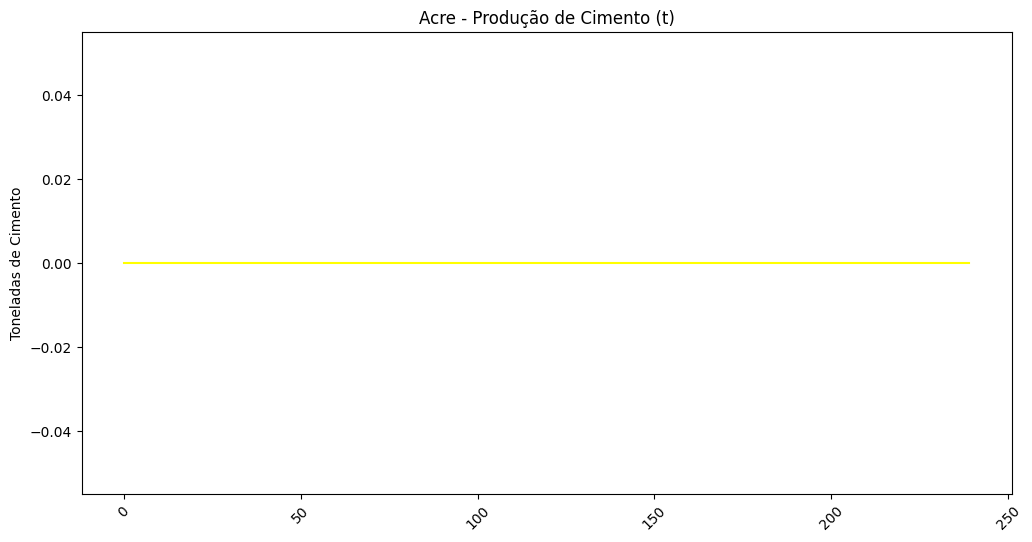

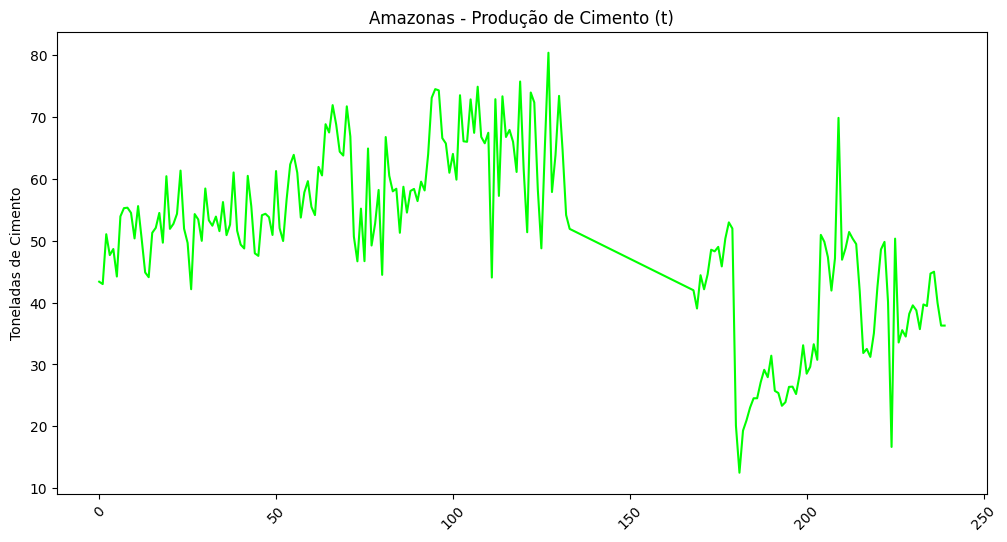

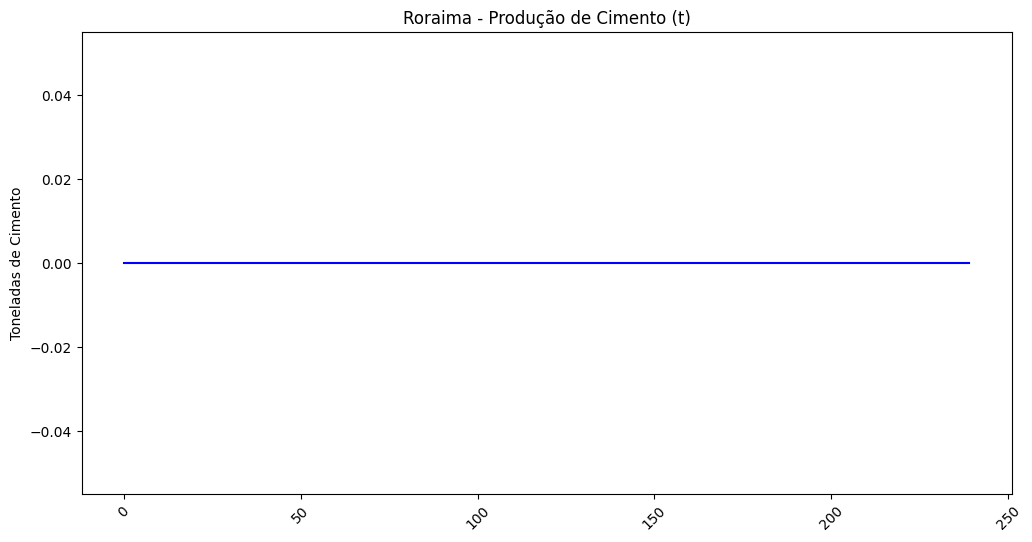

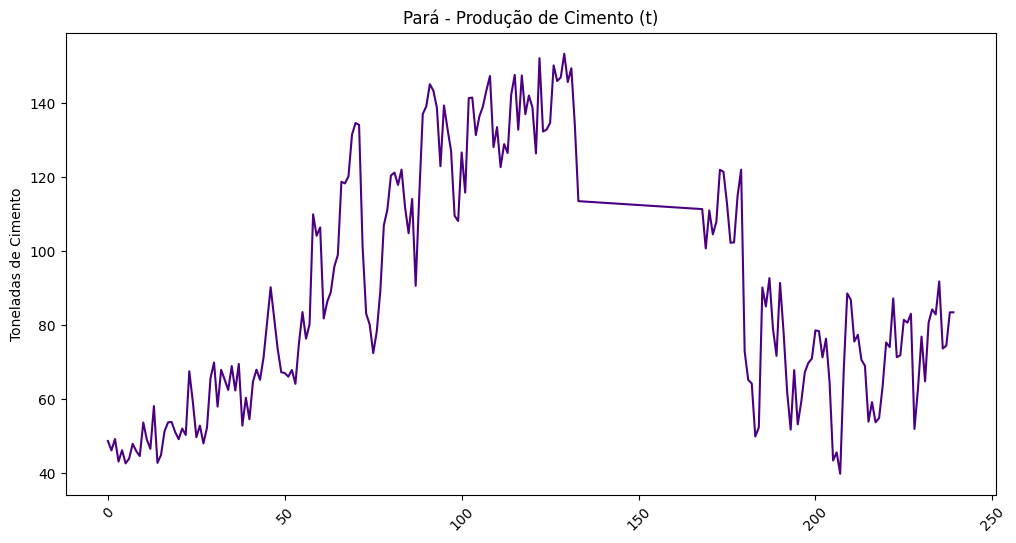

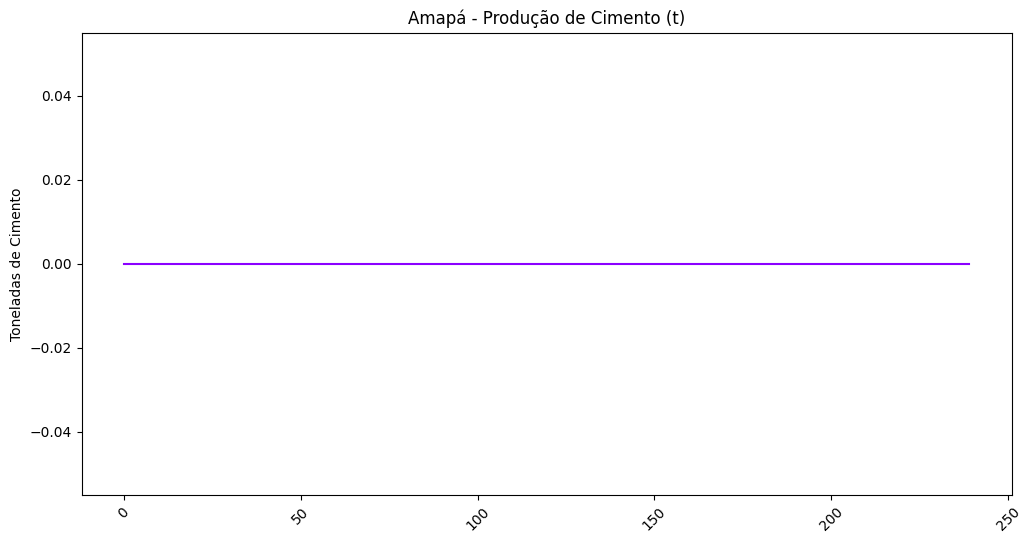

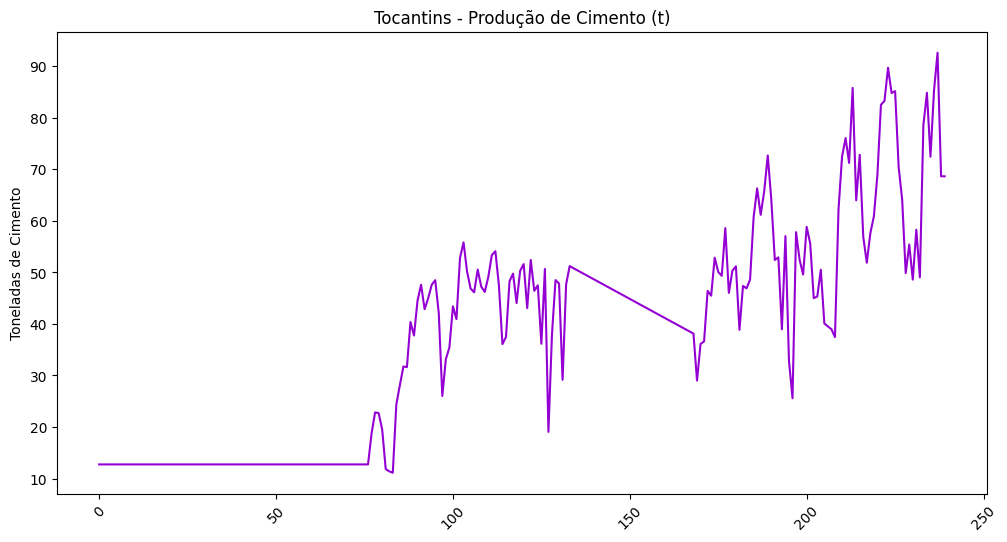

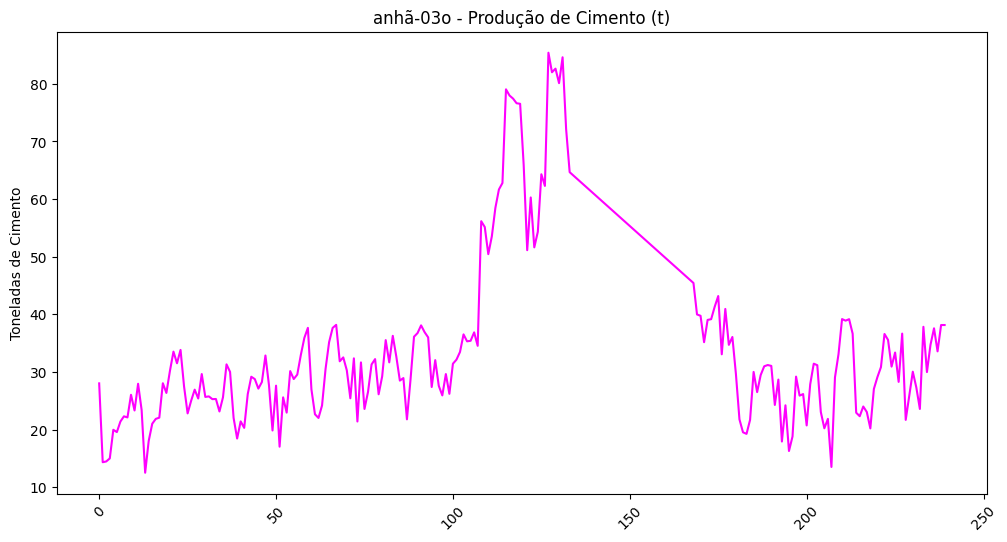

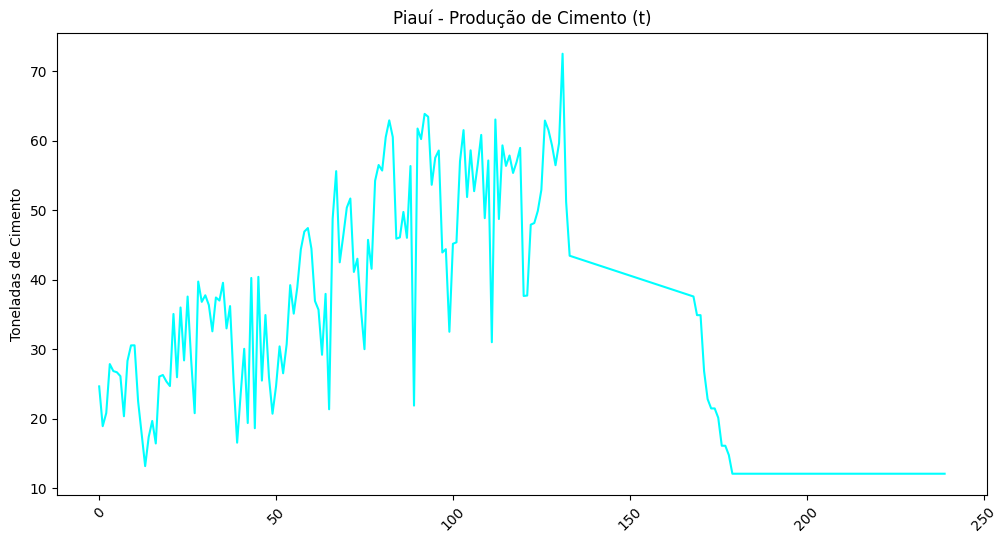

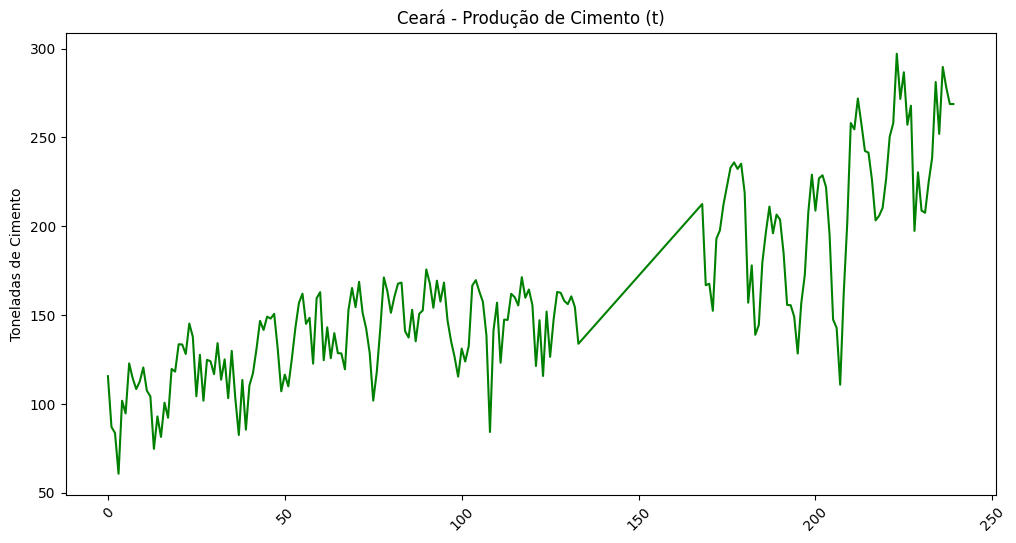

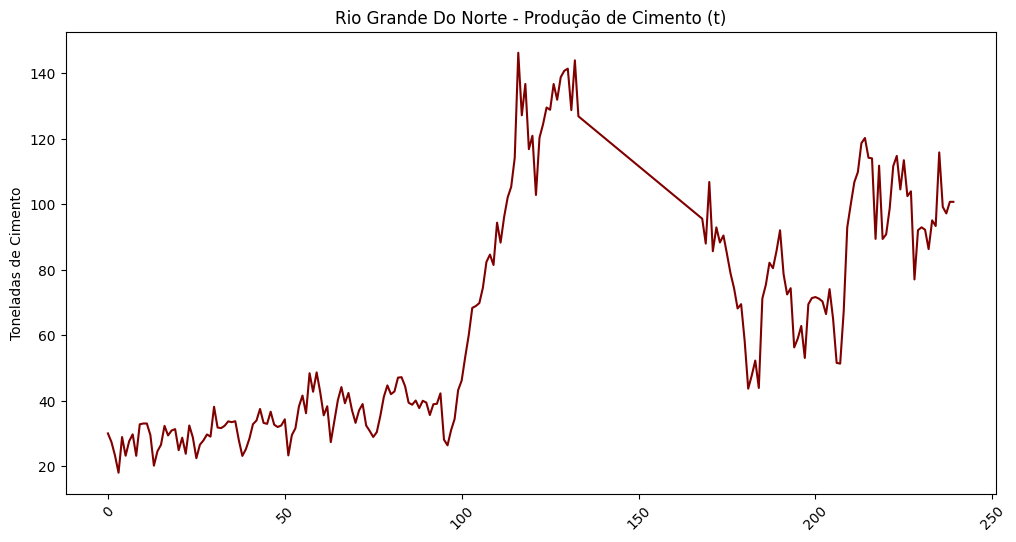

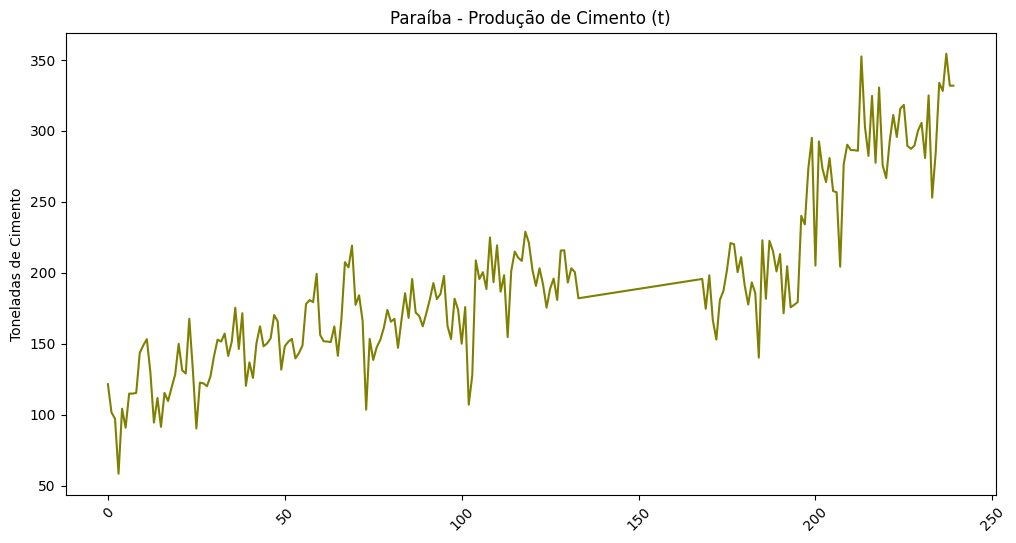

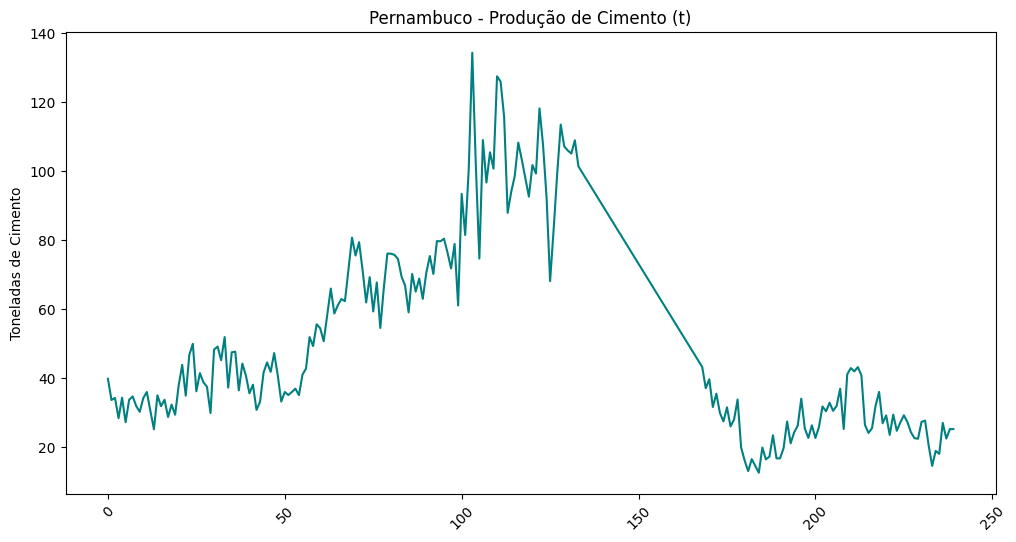

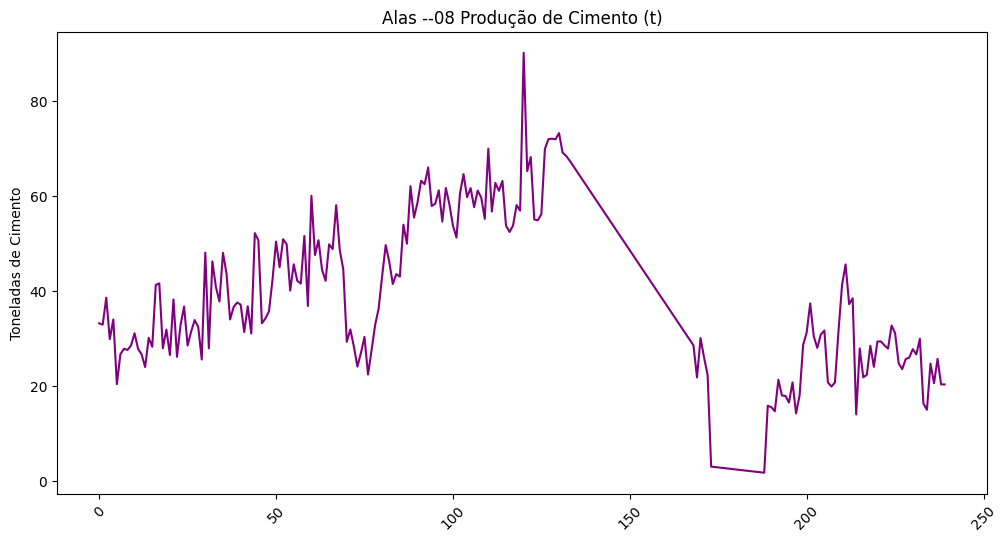

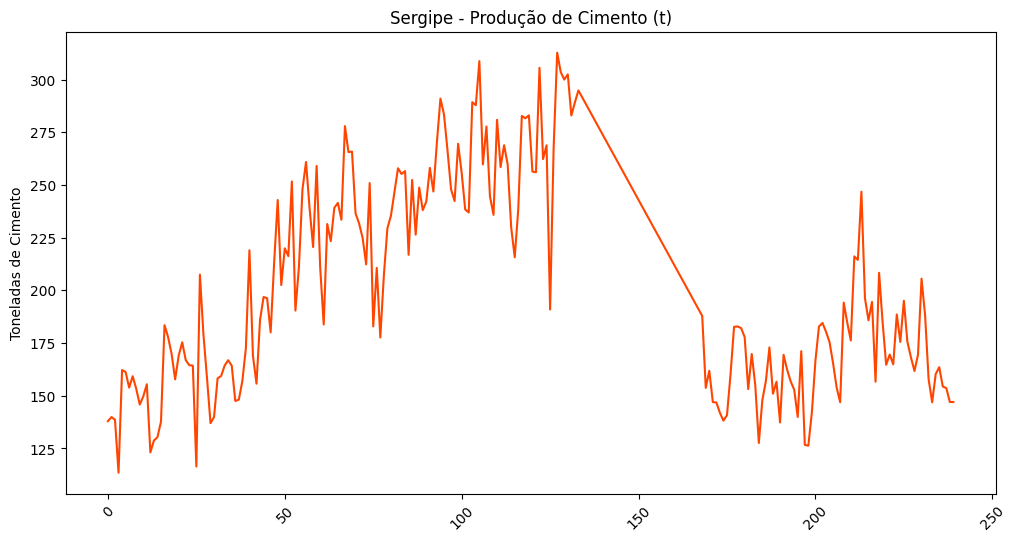

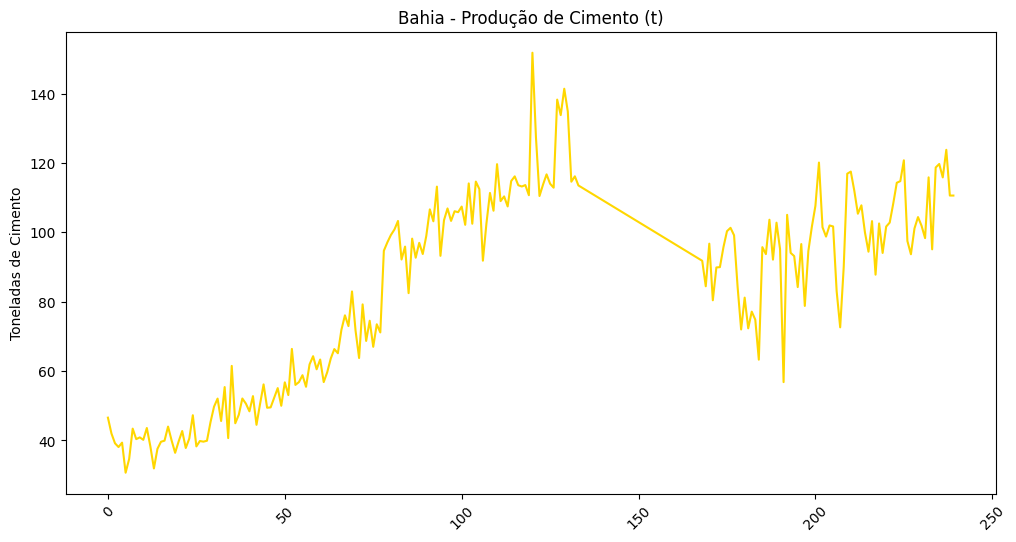

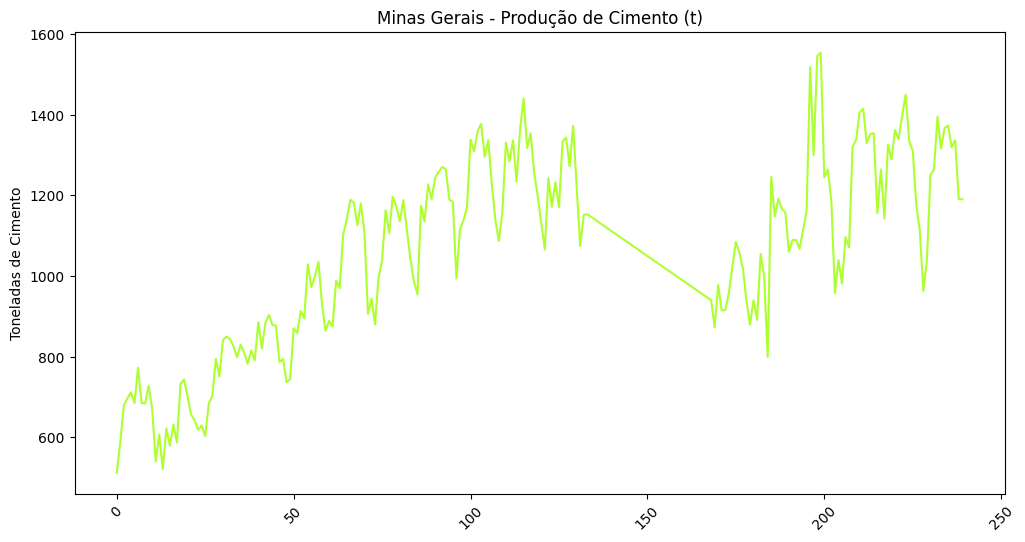

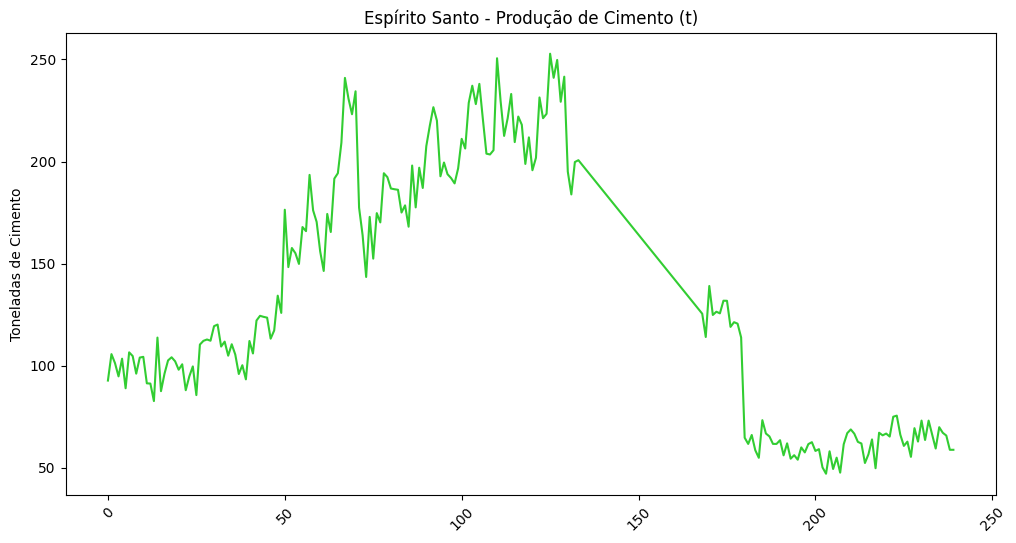

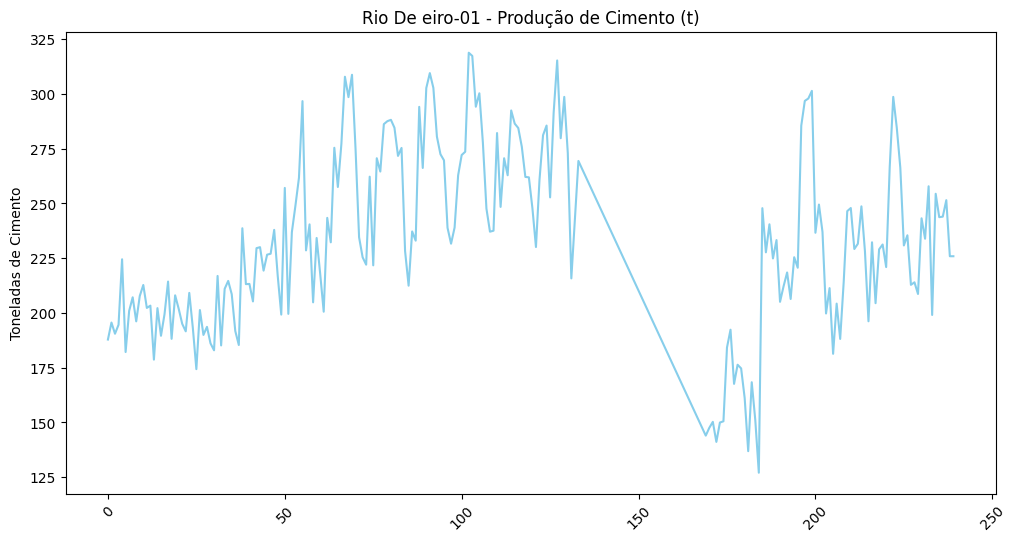

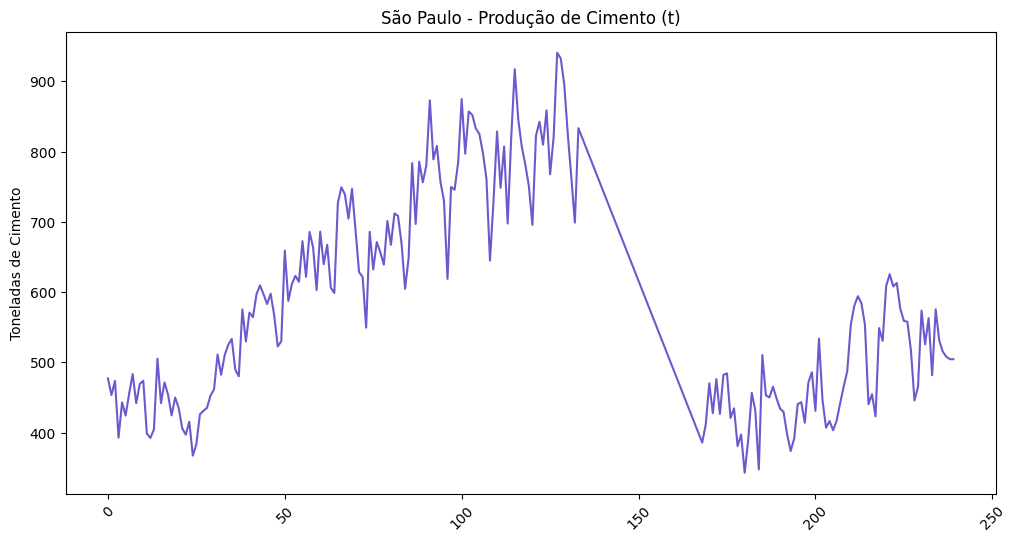

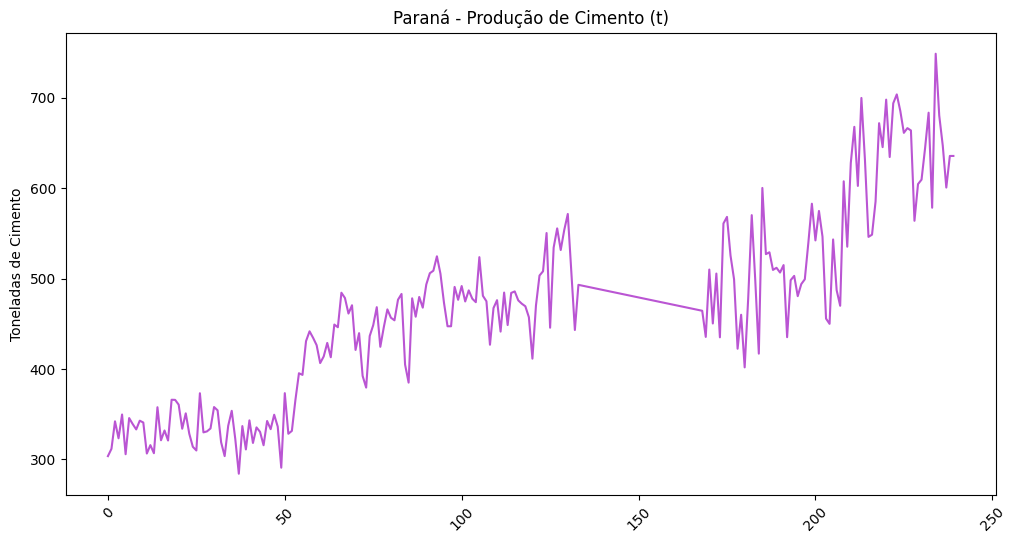

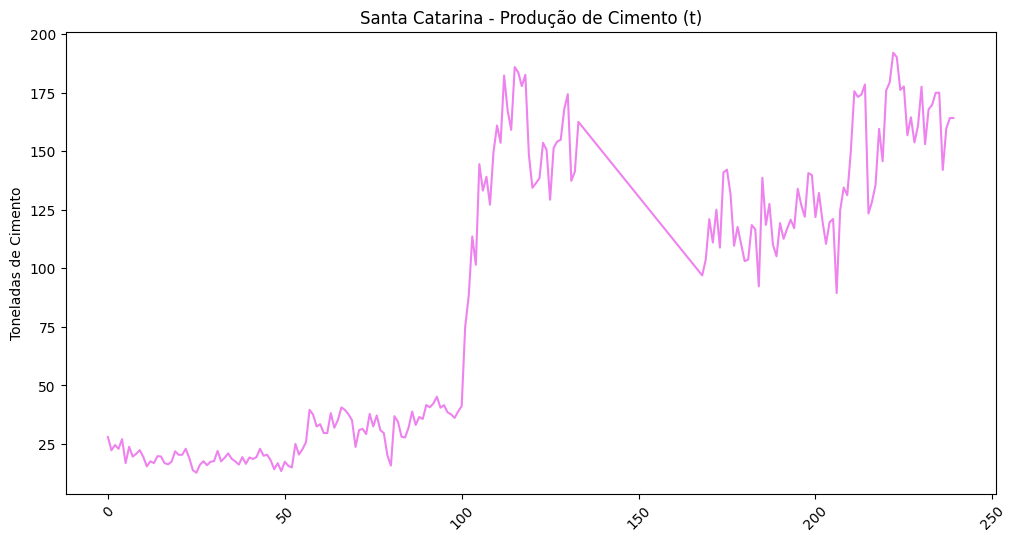

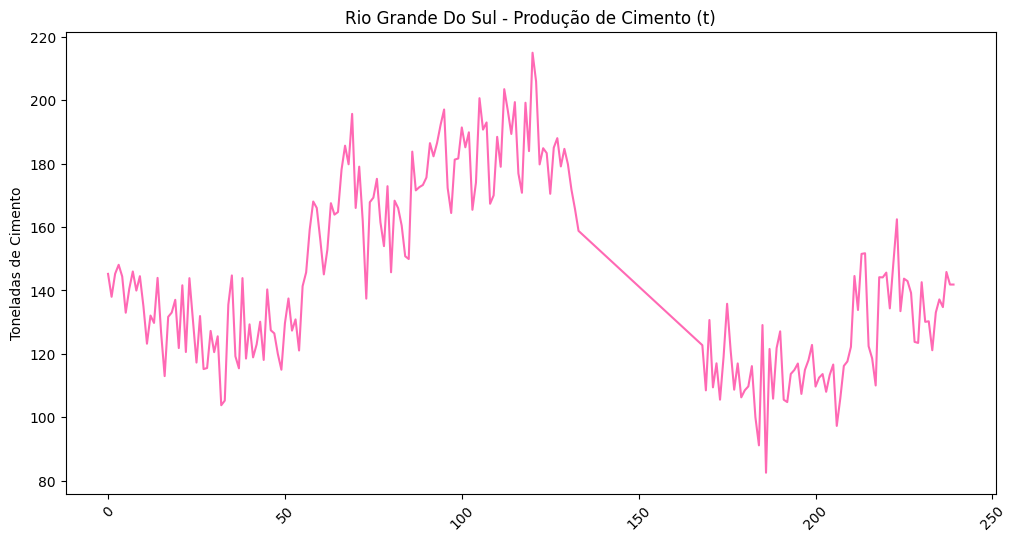

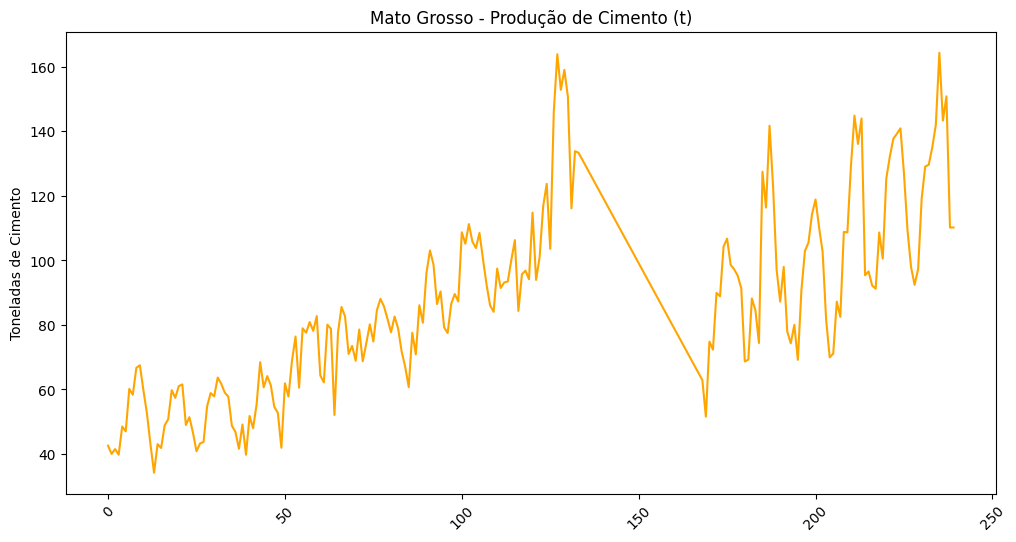

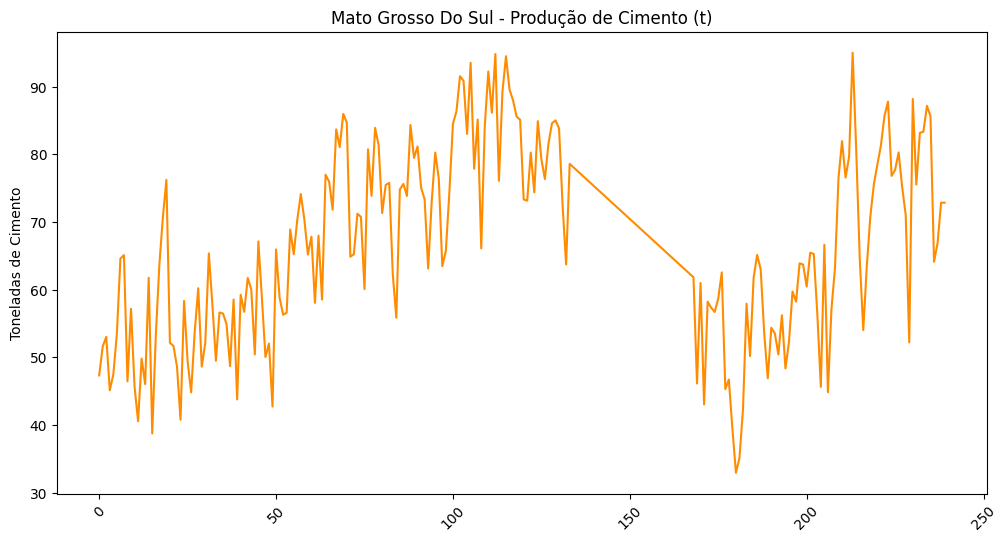

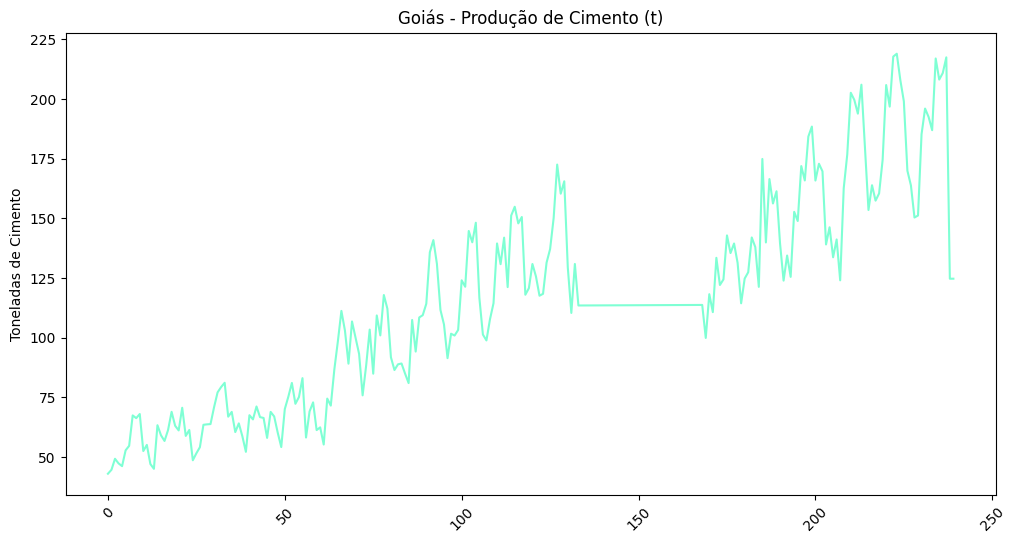

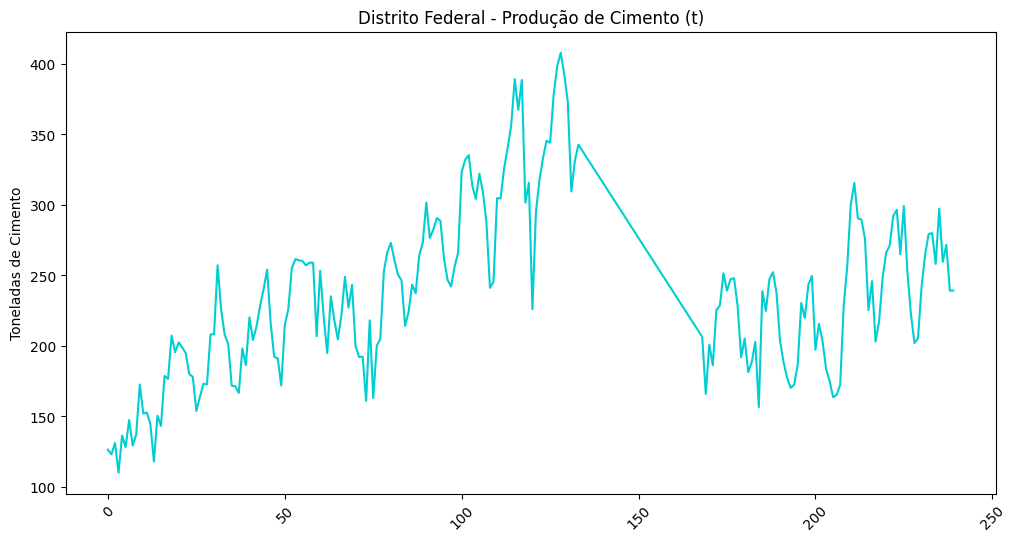

In [10]:
colors = ['#FF0000', '#FF7F00', '#FFFF00', '#00FF00', '#0000FF', '#4B0082', '#8B00FF', '#9400D3', '#FF00FF',
          '#00FFFF', '#008000', '#800000', '#808000', '#008080', '#800080', '#FF4500', '#FFD700', '#ADFF2F',
          '#32CD32', '#87CEEB', '#6A5ACD', '#BA55D3', '#EE82EE', '#FF69B4', '#FFA500', '#FF8C00', '#7FFFD4',
          '#00CED1']

for i, column in enumerate(df.columns):
    if i > 1:
        plot_column(df[column], color=colors[i])

In [11]:
df_cma = df.copy()
for column in df.columns:
    if column != 'Ano': 
        df_cma[column] = centered_moving_average(df_cma[column], (0, len(df_cma) - 1), 12)
df_cma

Ano  Rondônia - Produção de Cimento (t)  \
0    2003-01                            4.987000   
1    2003-02                            4.987000   
2    2003-03                            4.987000   
3    2003-04                            4.987000   
4    2003-05                            4.987000   
..       ...                                 ...   
235  2022-08                           20.086529   
236  2022-09                           19.588187   
237  2022-10                           19.466333   
238  2022-11                           19.799643   
239  2022-12                           19.885462   

     Acre - Produção de Cimento (t)  Amazonas - Produção de Cimento (t)  \
0                               0.0                           50.266308   
1                               0.0                           49.881571   
2                               0.0                           49.496800   
3                               0.0                           49.608688   
4                               0.0                           49.755059   
..                              ...                                 ...   
235                             0.0                           37.897235   
236                             0.0                           37.760375   
237                             0.0                           39.167400   
238                             0.0                           38.368786   
239                             0.0                           38.739385   

     Roraima - Produção de Cimento (t)  Pará - Produção de Cimento (t)  \
0                                  0.0                       46.693692   
1                                  0.0                       47.506714   
2                                  0.0                       47.187533   
3                                  0.0                       47.039563   
4                                  0.0                       47.287882   
..                                 ...                             ...   
235                                0.0                       76.401588   
236                                0.0                       76.721375   
237                                0.0                       77.050133   
238                                0.0                       76.740357   
239                                0.0                       76.442308   

     Amapá - Produção de Cimento (t)  Tocantins - Produção de Cimento (t)  \
0                                0.0                            12.733000   
1                                0.0                            12.733000   
2                                0.0                            12.733000   
3                                0.0                            12.733000   
4                                0.0                            12.733000   
..                               ...                                  ...   
235                              0.0                            70.980588   
236                              0.0                            69.808813   
237                              0.0                            68.808800   
238                              0.0                            67.639286   
239                              0.0                            67.420385   

     anhã-03o - Produção de Cimento (t)  Piauí - Produção de Cimento (t)  ...  \
0                             21.371769                        24.783538  ...   
1                             20.738714                        23.954571  ...   
2                             20.558067                        23.516067  ...   
3                             20.586562                        23.276625  ...   
4                             20.661059                        22.874412  ...   
..                                  ...                              ...  ...   
235                           31.954471                        12.084000  ...   
236                  

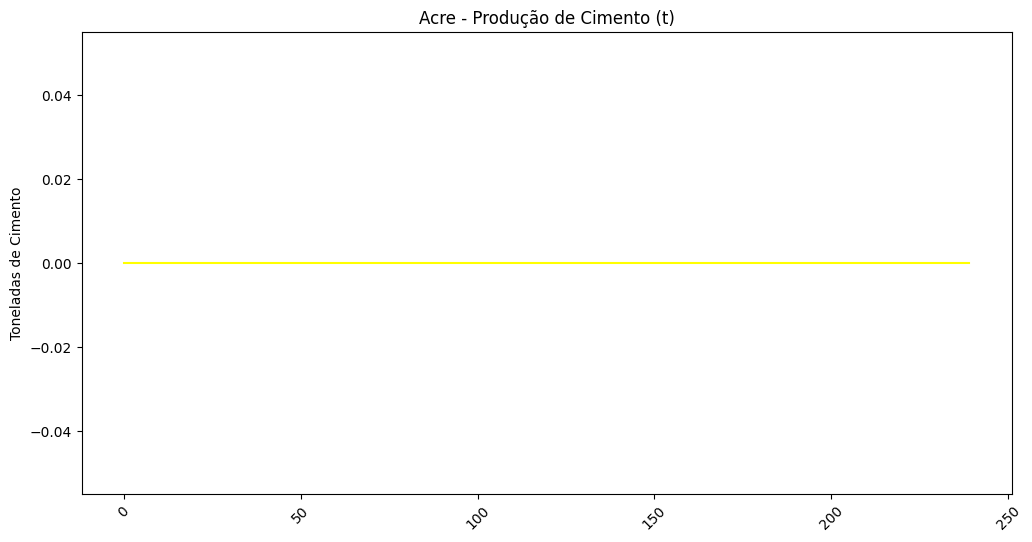

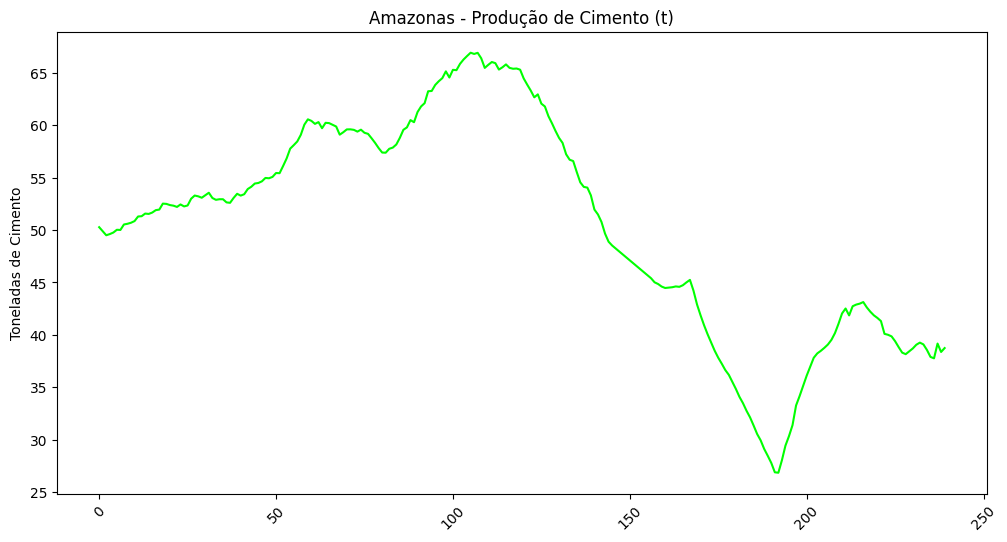

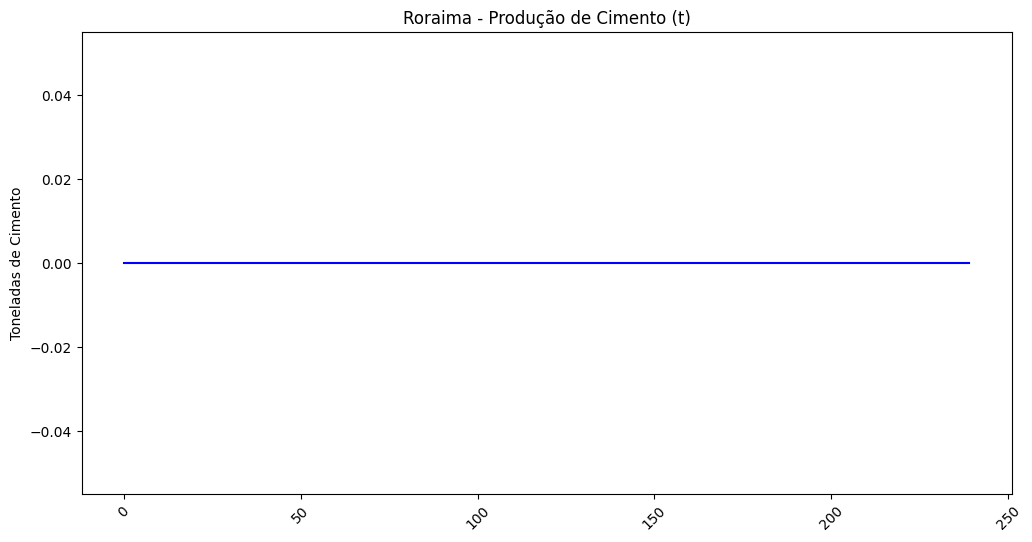

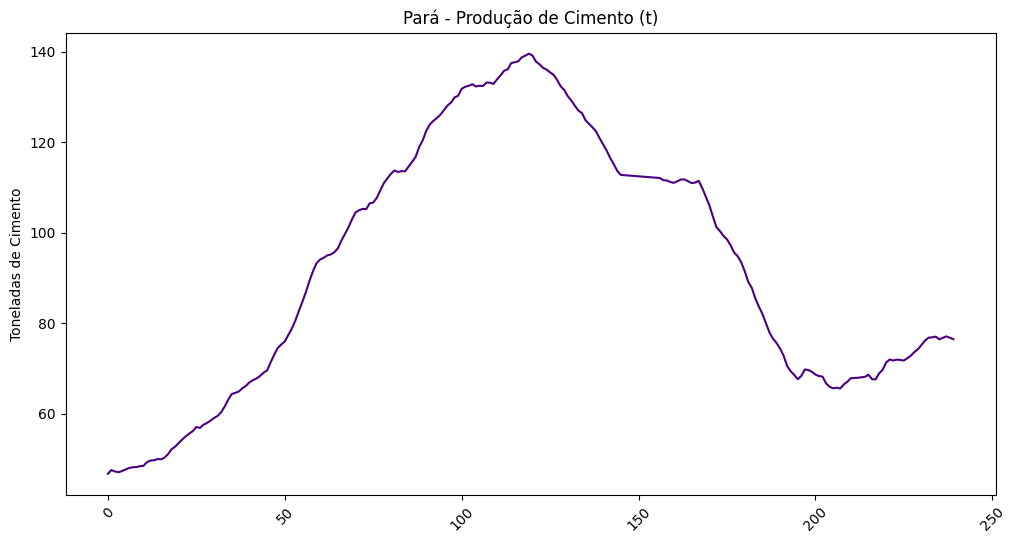

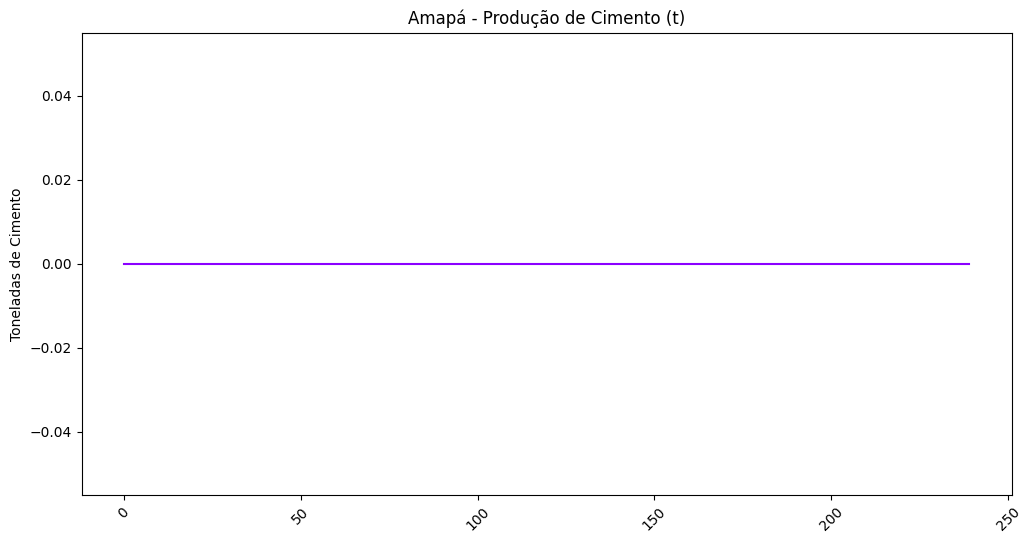

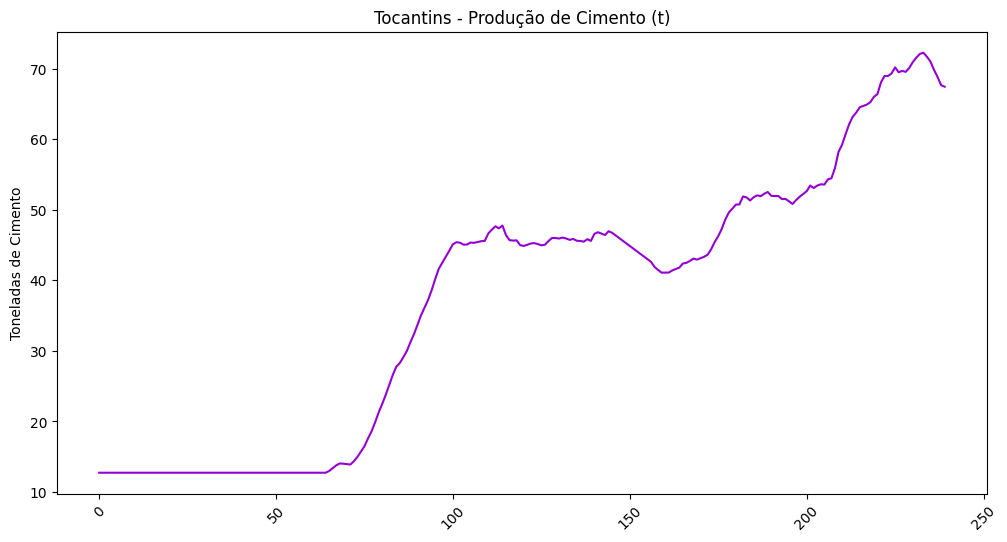

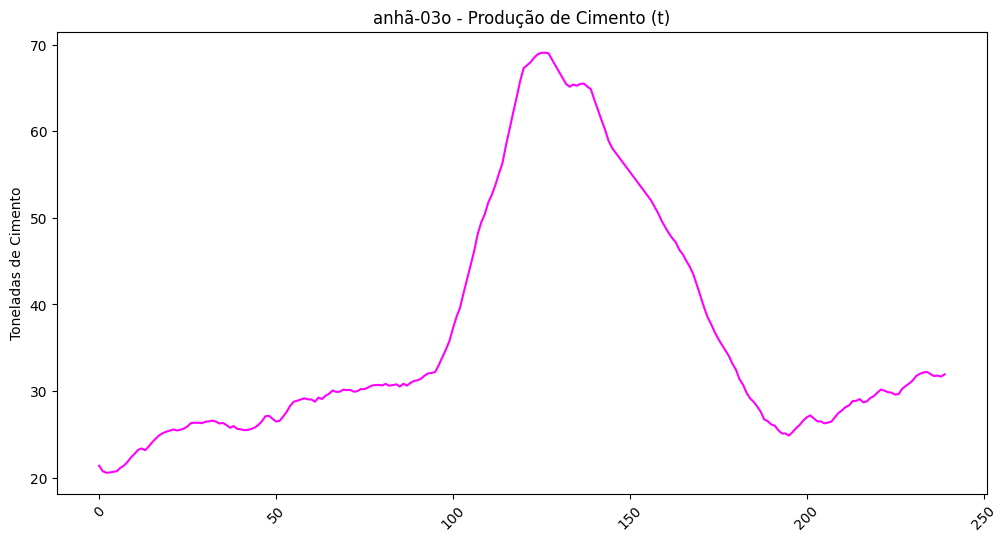

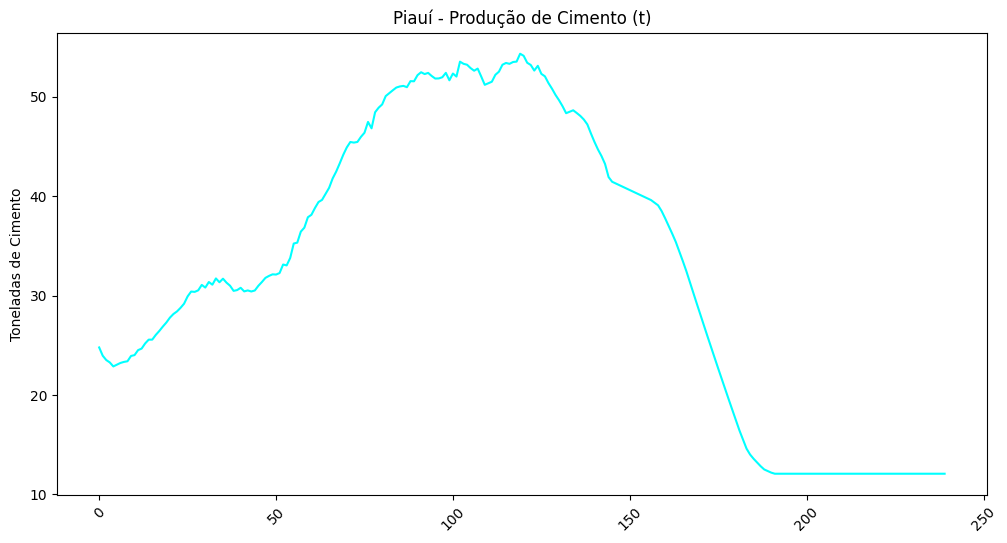

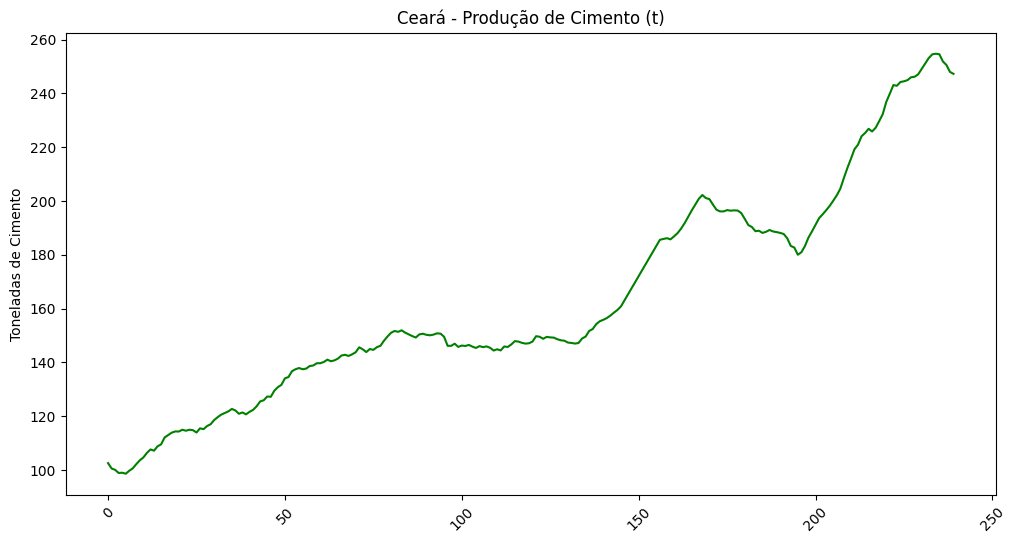

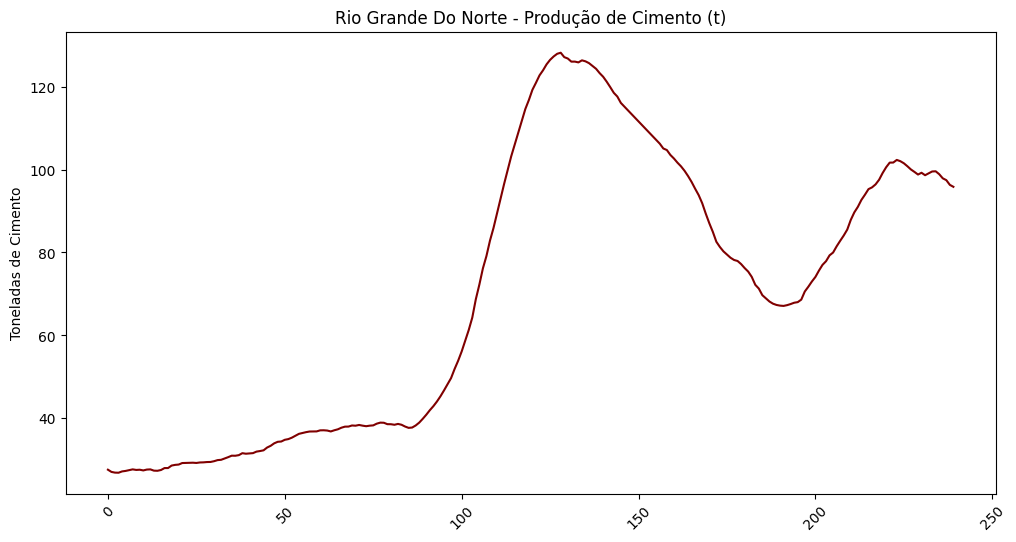

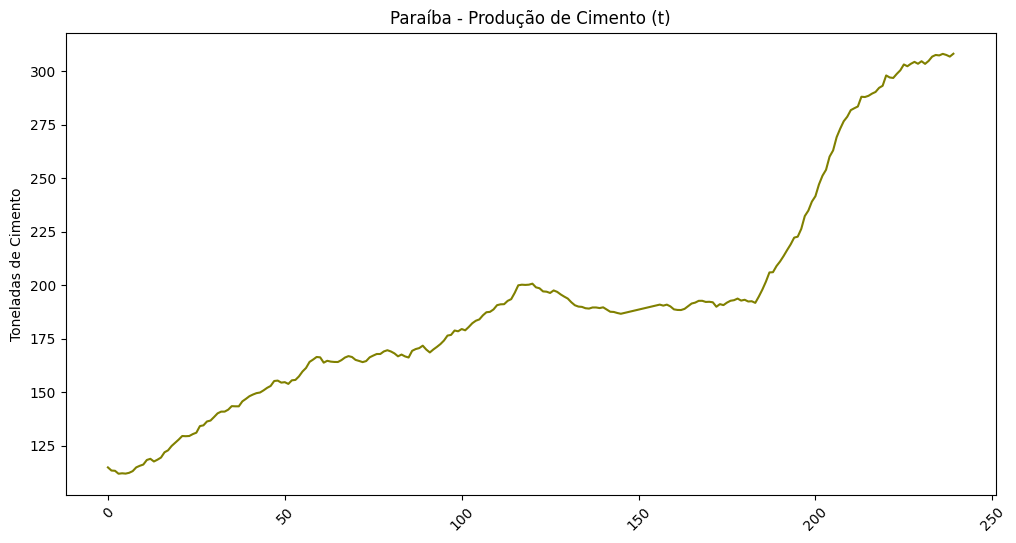

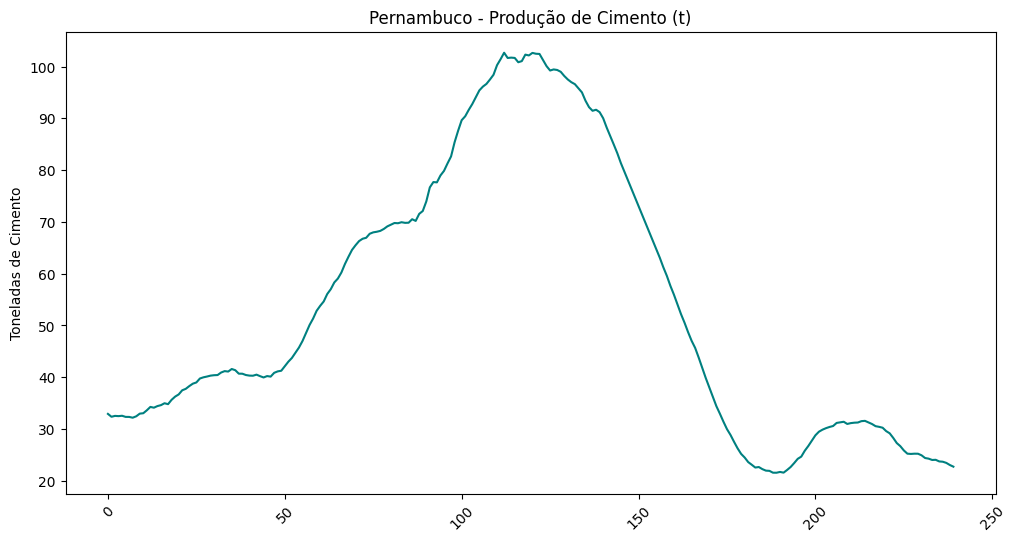

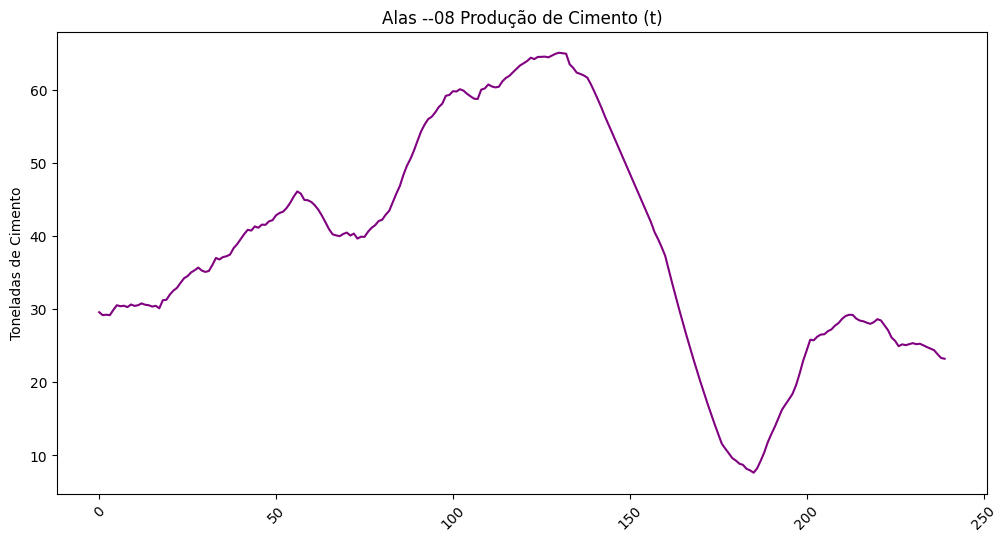

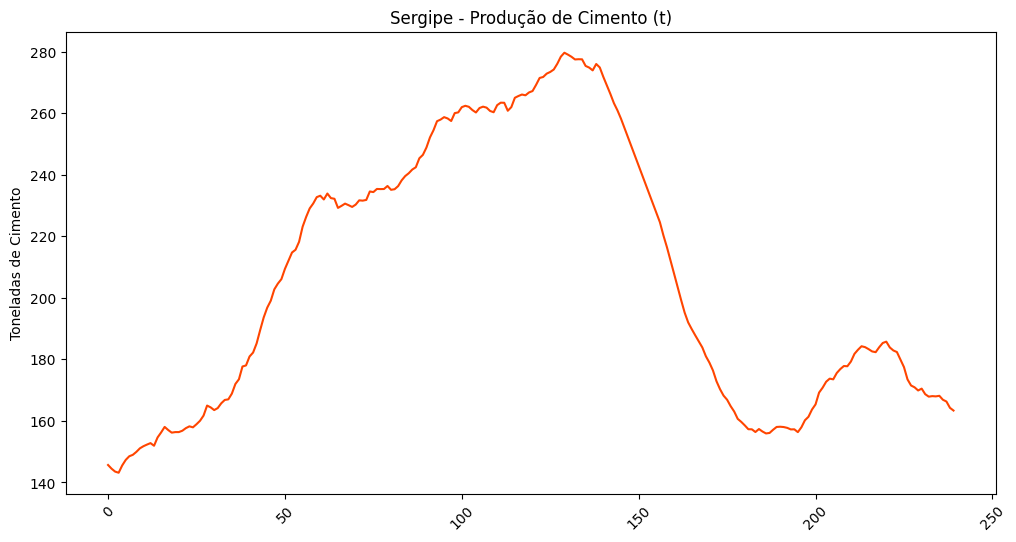

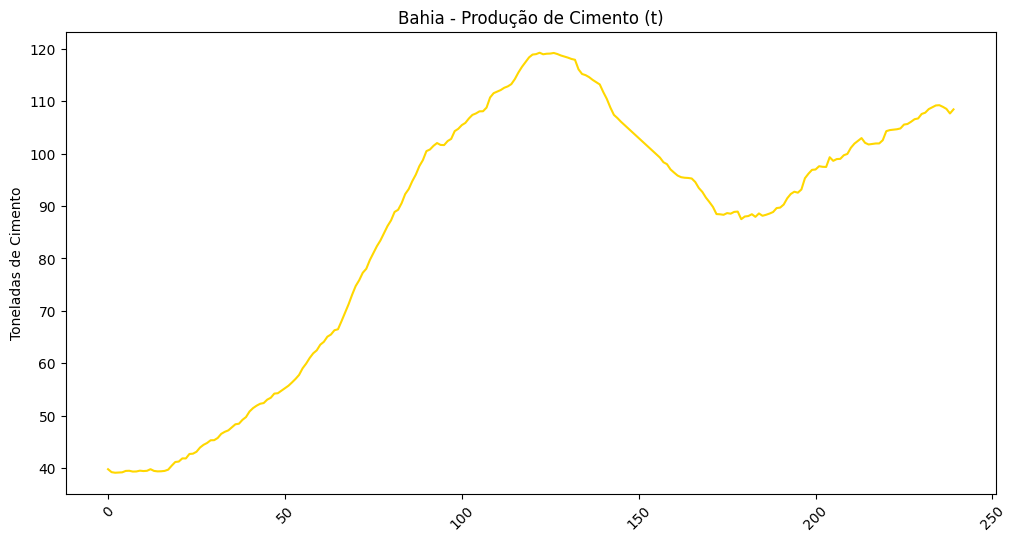

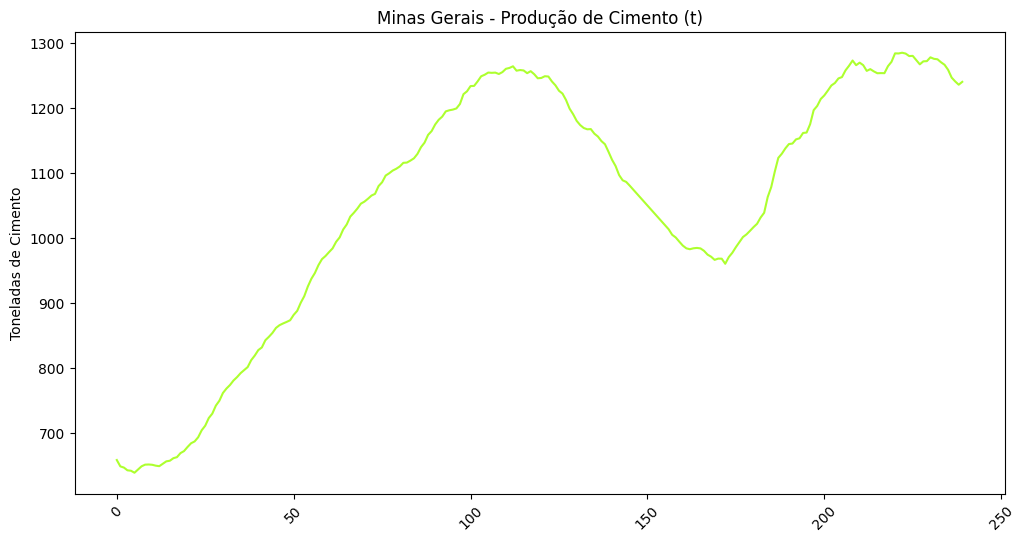

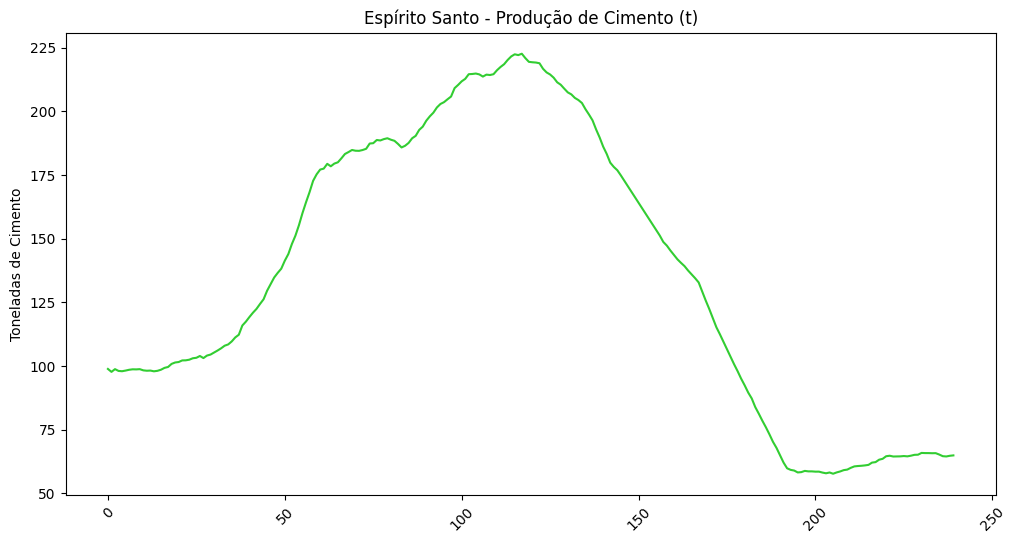

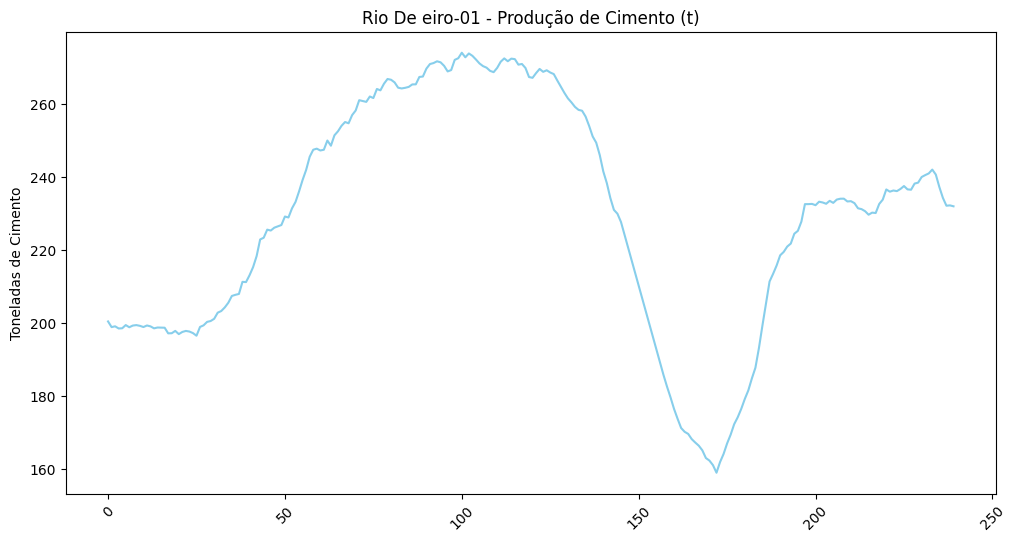

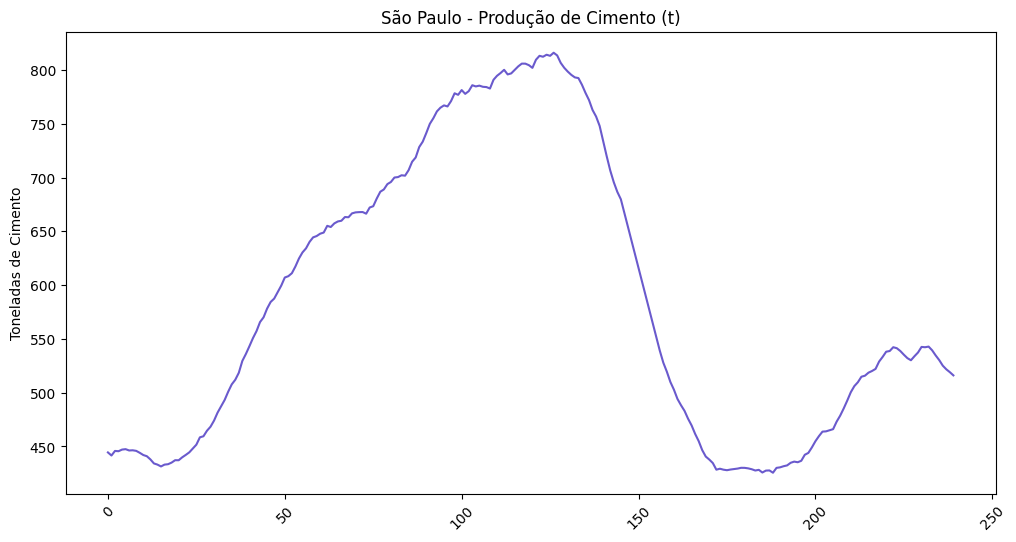

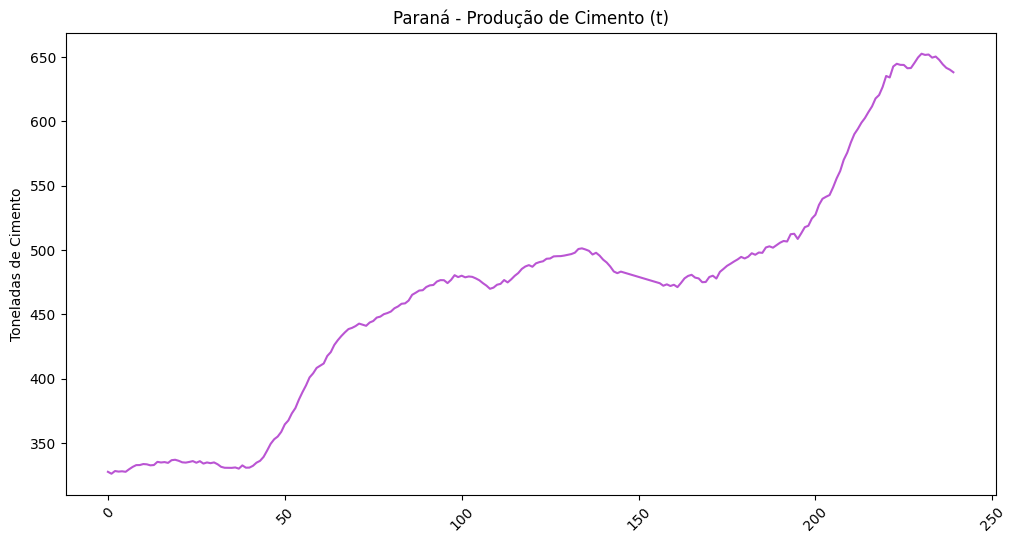

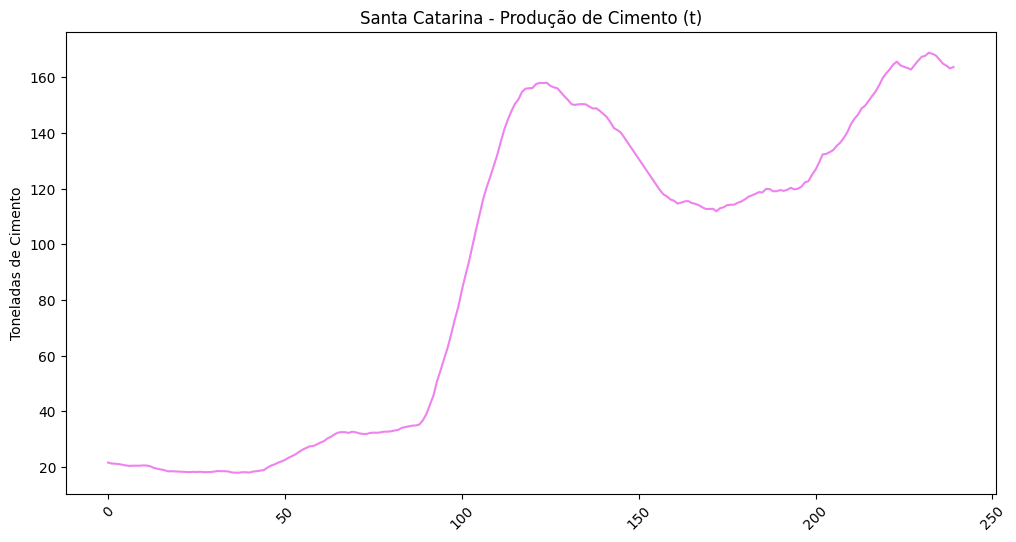

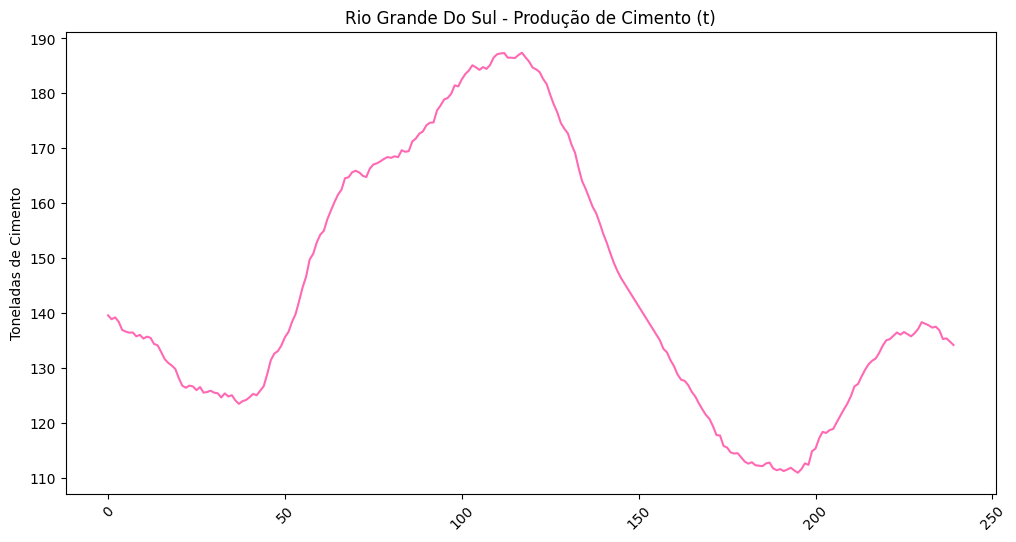

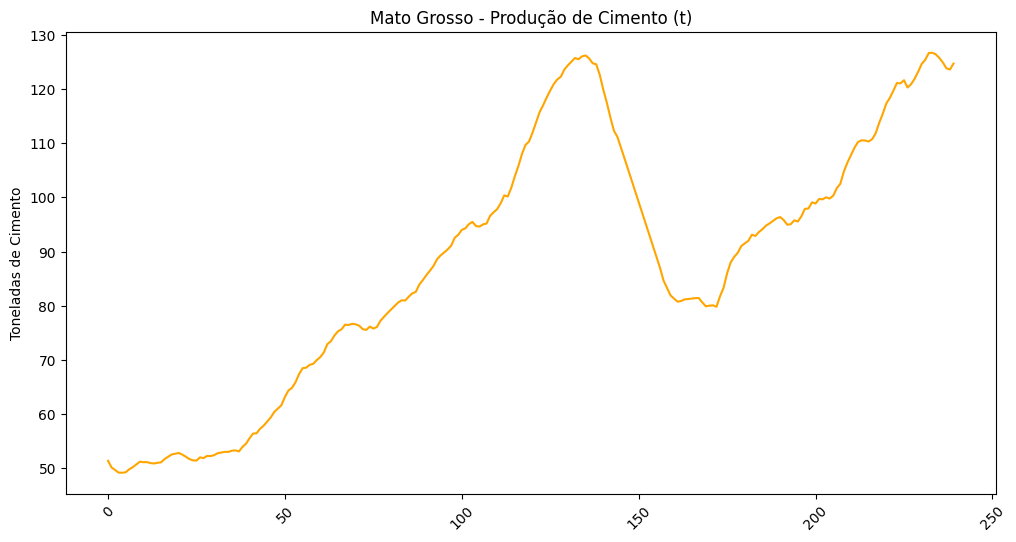

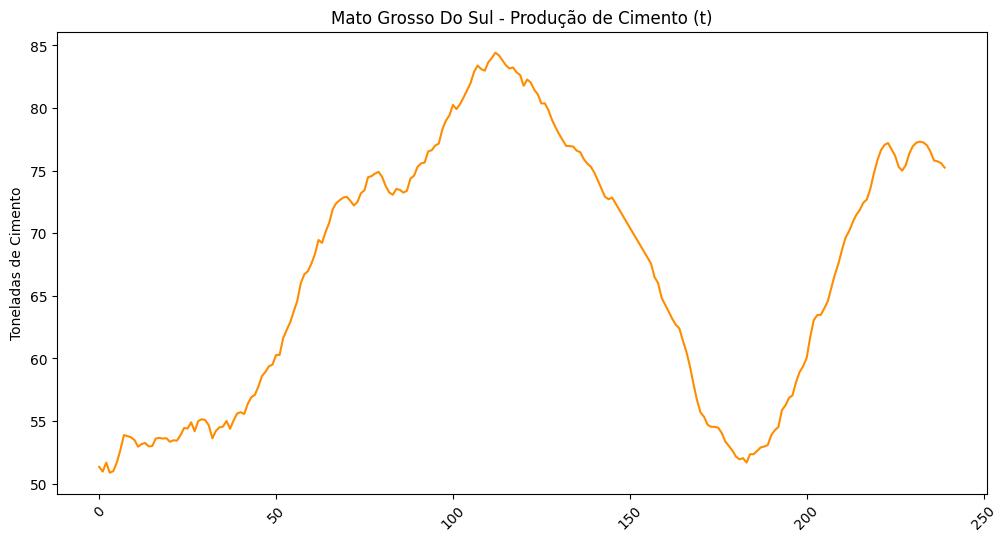

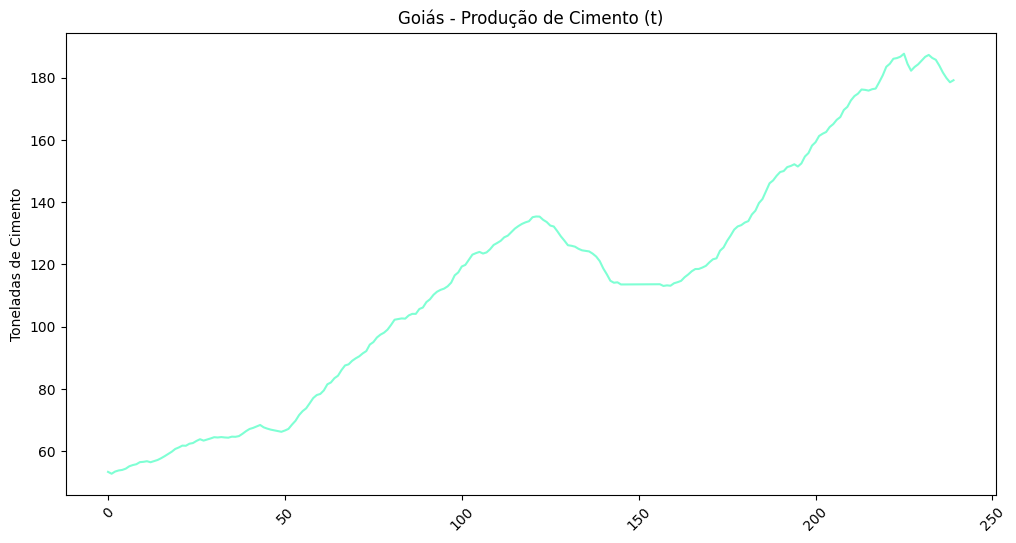

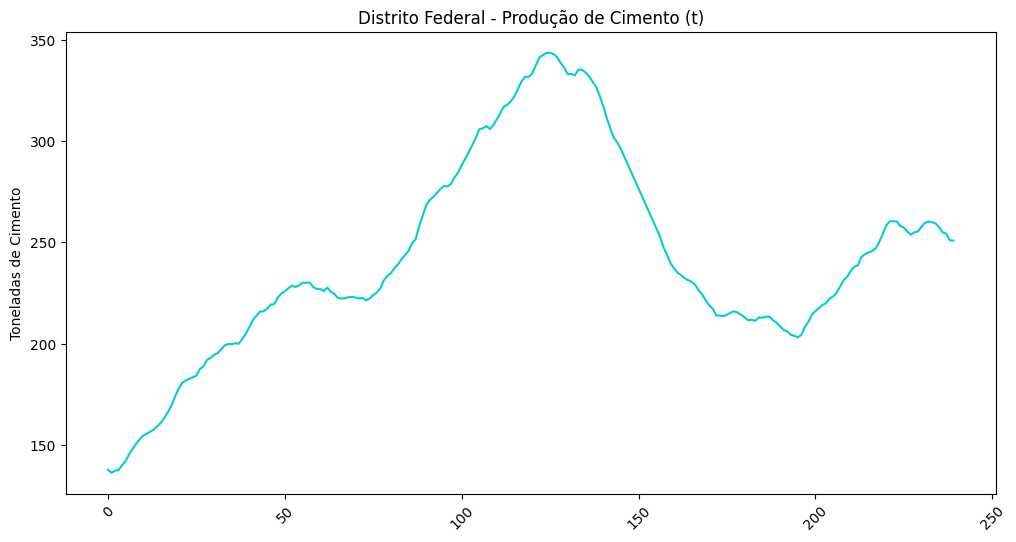

In [12]:
for i, column in enumerate(df_cma.columns):
    if i > 1:
        plot_column(df_cma[column], color=colors[i])

In [13]:
df_year = df_cma.copy()
df_year['Ano'] = df_year['Ano'].str[:4]
df_year = df_year.groupby('Ano').sum()
df_year

Rondônia - Produção de Cimento (t)  Acre - Produção de Cimento (t)  \
Ano                                                                        
2003                           59.844000                             0.0   
2004                           59.844000                             0.0   
2005                           59.844000                             0.0   
2006                           59.844000                             0.0   
2007                           59.844000                             0.0   
2008                           67.920600                             0.0   
2009                          221.515000                             0.0   
2010                          503.762400                             0.0   
2011                          672.442400                             0.0   
2012                          678.669280                             0.0   
2013                          556.597886                             0.0   
2014                          374.392703                             0.0   
2015                          255.113017                             0.0   
2016                          192.650674                             0.0   
2017                          193.969360                             0.0   
2018                          209.359280                             0.0   
2019                          206.366520                             0.0   
2020                          244.343240                             0.0   
2021                          260.545880                             0.0   
2022                          244.524358                             0.0   

      Amazonas - Produção de Cimento (t)  Roraima - Produção de Cimento (t)  \
Ano                                                                           
2003                          602.968635                                0.0   
2004                          624.233160                                0.0   
2005                          635.789240                                0.0   
2006                          644.951800                                0.0   
2007                          687.725080                                0.0   
2008                          718.412440                                0.0   
2009                          702.141480                                0.0   
2010                          732.469240                                0.0   
2011                          788.094560                                0.0   
2012                          787.615360                                0.0   
2013                          738.560349                                0.0   
2014                          645.856362                                0.0   
2015                          567.019838                                0.0   
2016                          537.545659                                0.0   
2017                          471.104752                                0.0   
2018                          371.376320                                0.0   
2019                          397.720960                                0.0   
2020                          492.053280                                0.0   
2021                          489.214320                                0.0   
2022                          463.187965                                0.0   

      Pará - Produção de Cimento (t)  Amapá - Produção de Cimento (t)  \
Ano                                                                     
2003                      573.589376                              0.0   
2004                      623.424040                              0.0   
2005                      711.476800                              0.0   
2006                      814.238200                              0.0   
2007                      990.941120                              0.0   
2008                     1182.044360                              0.0   
2009      

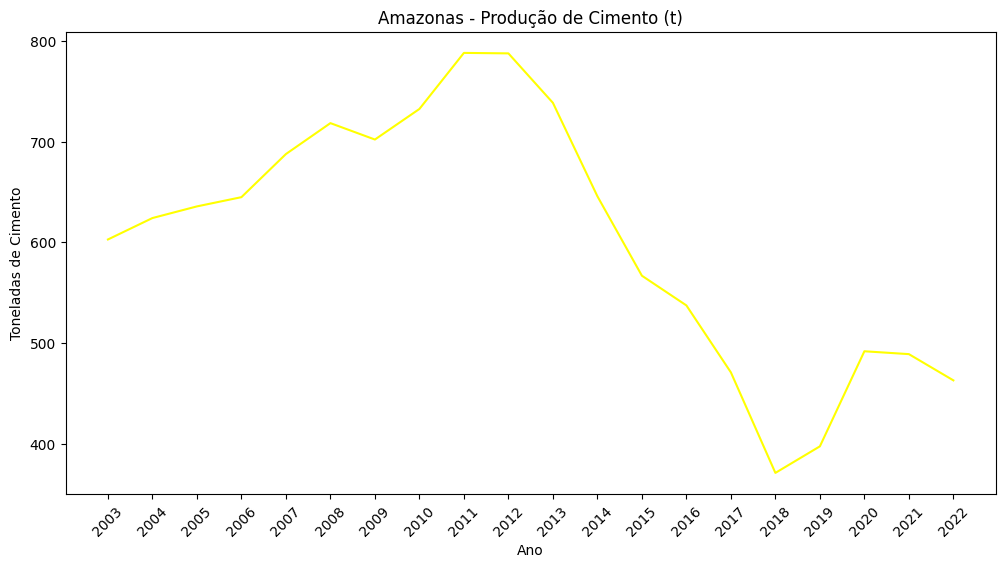

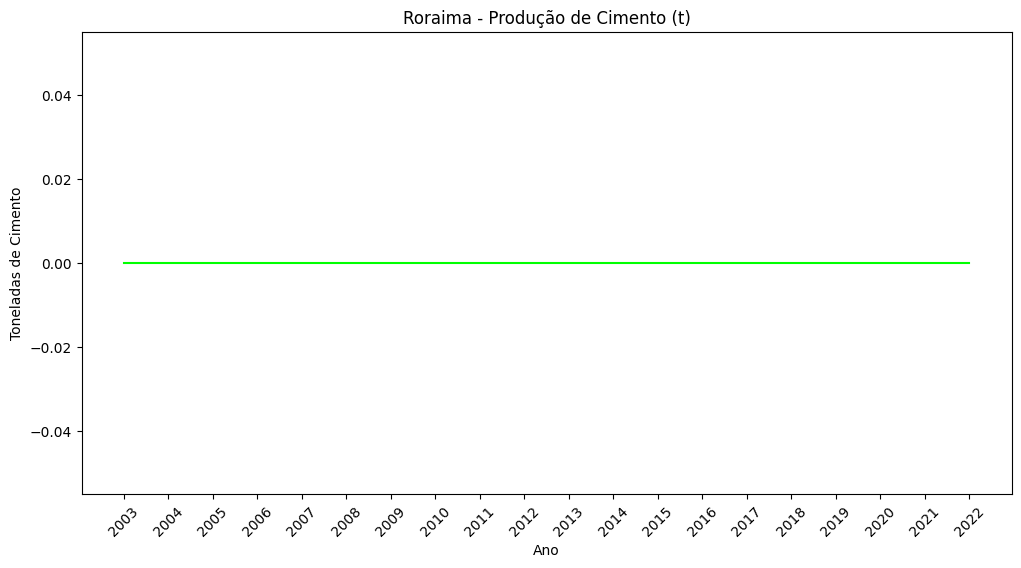

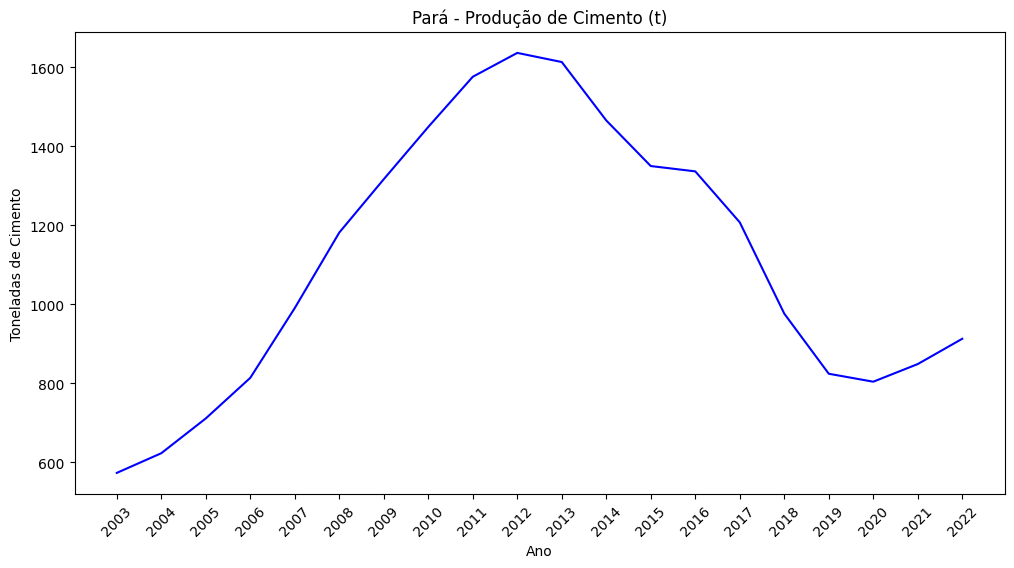

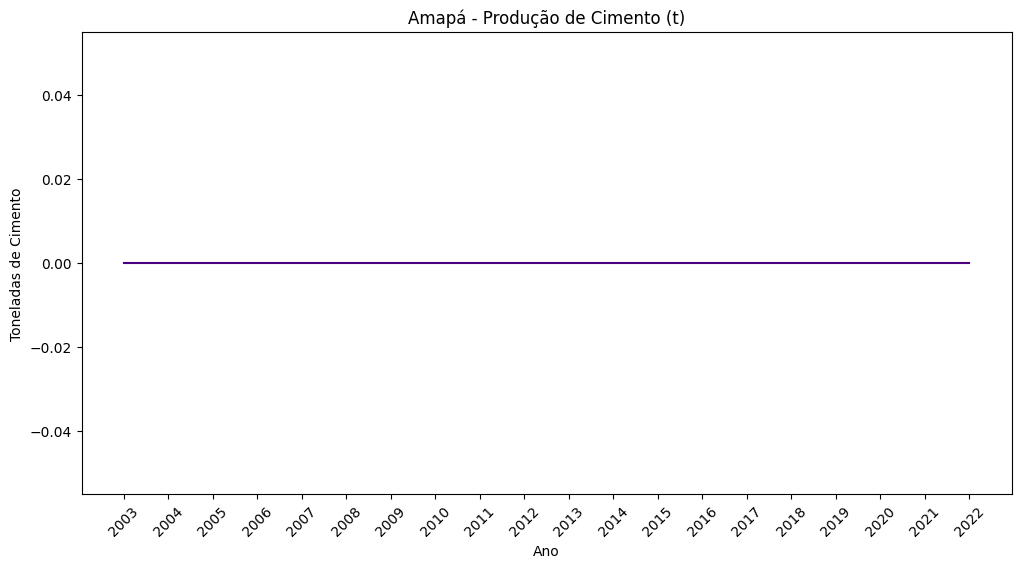

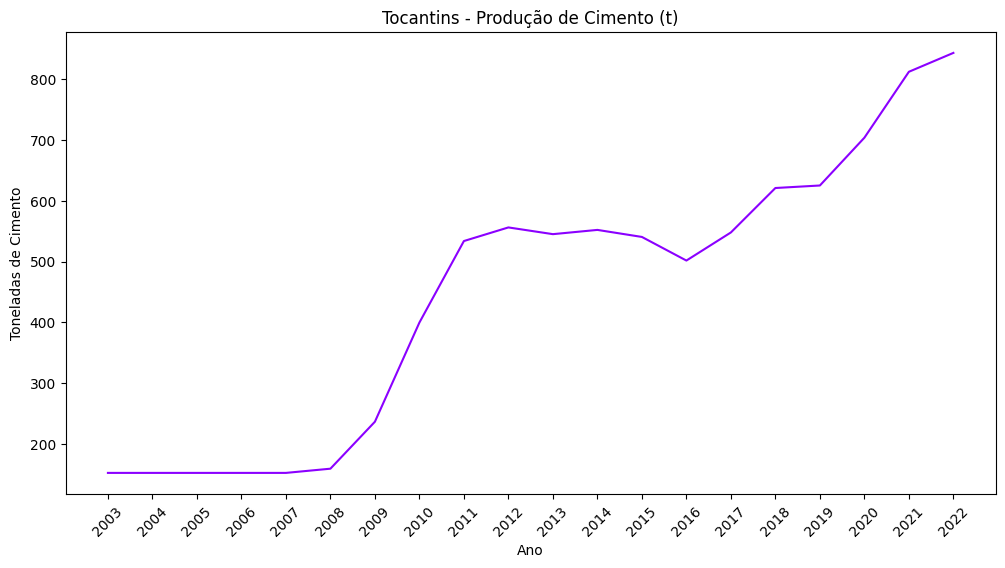

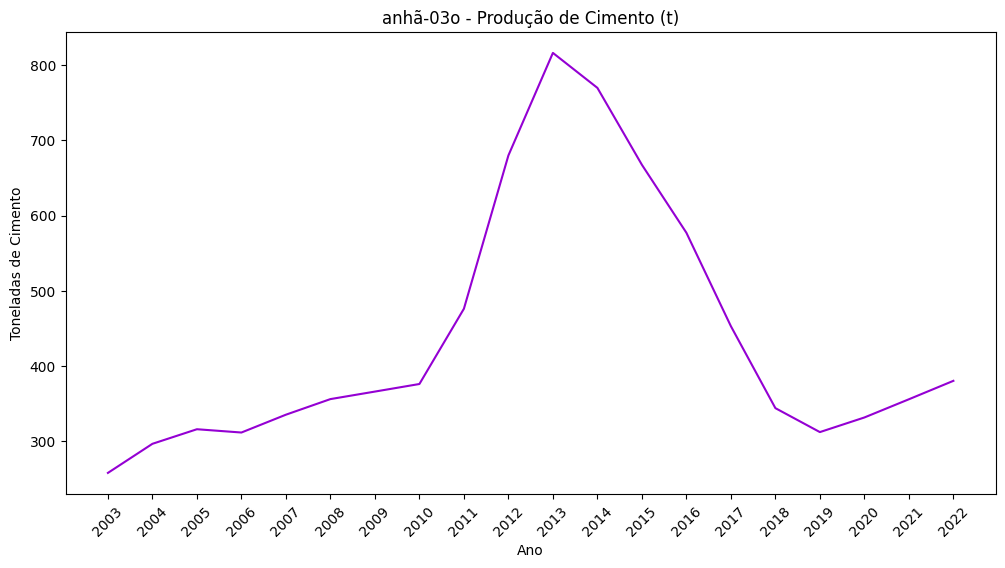

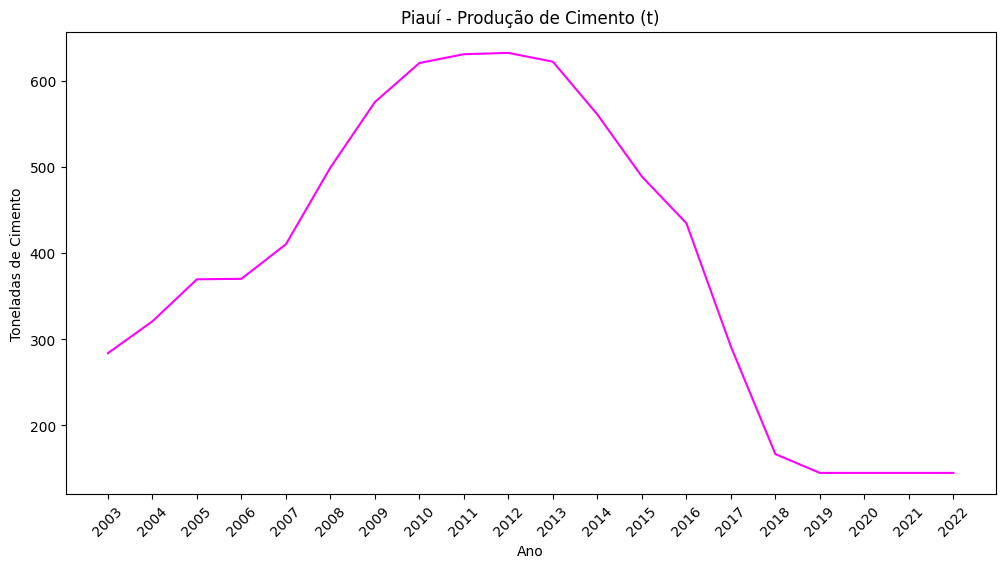

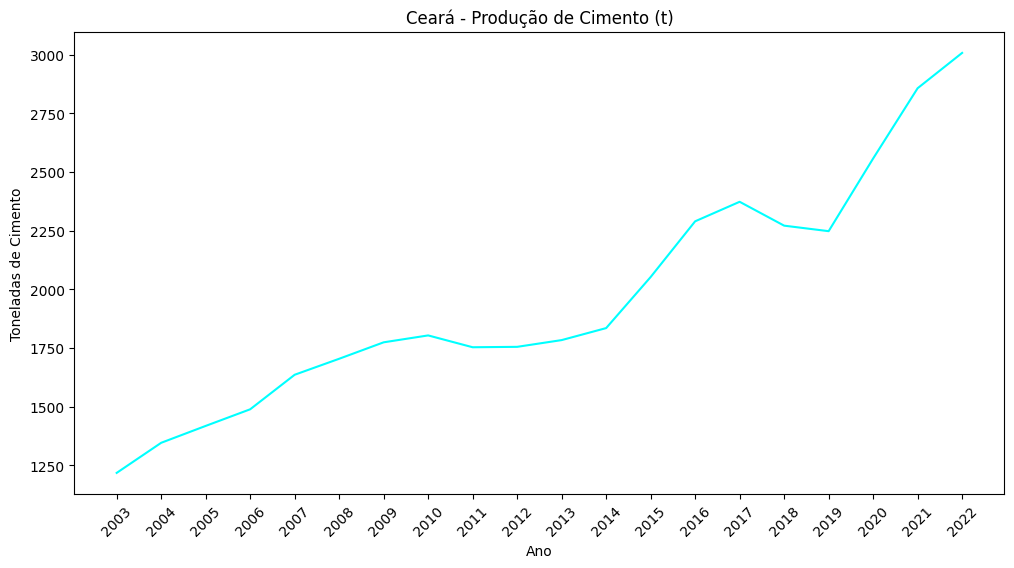

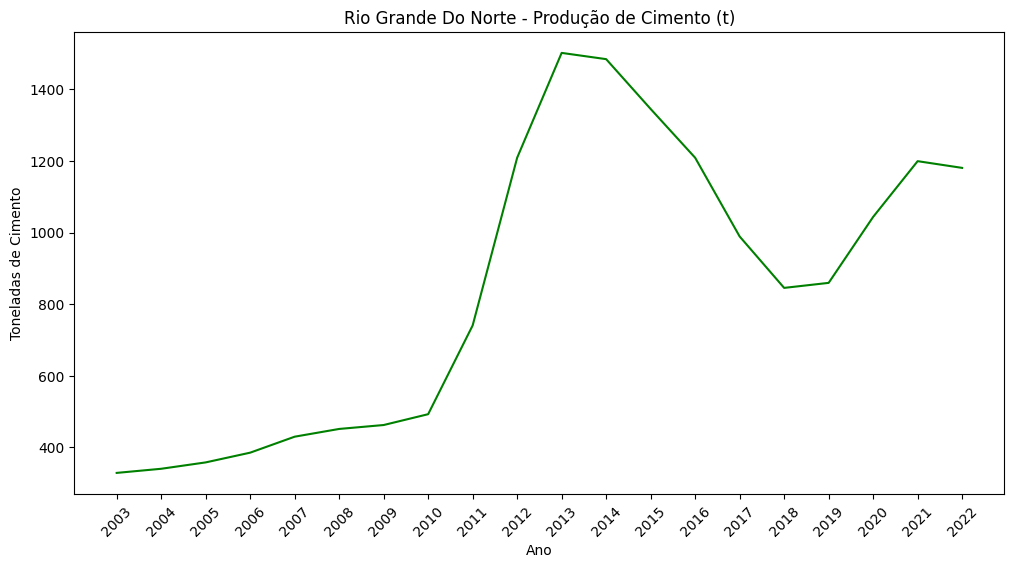

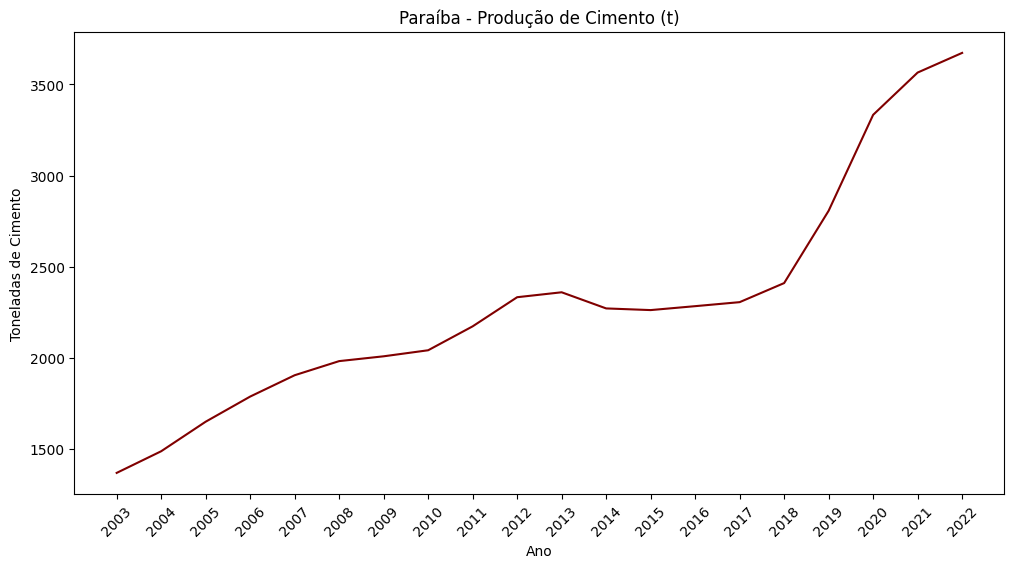

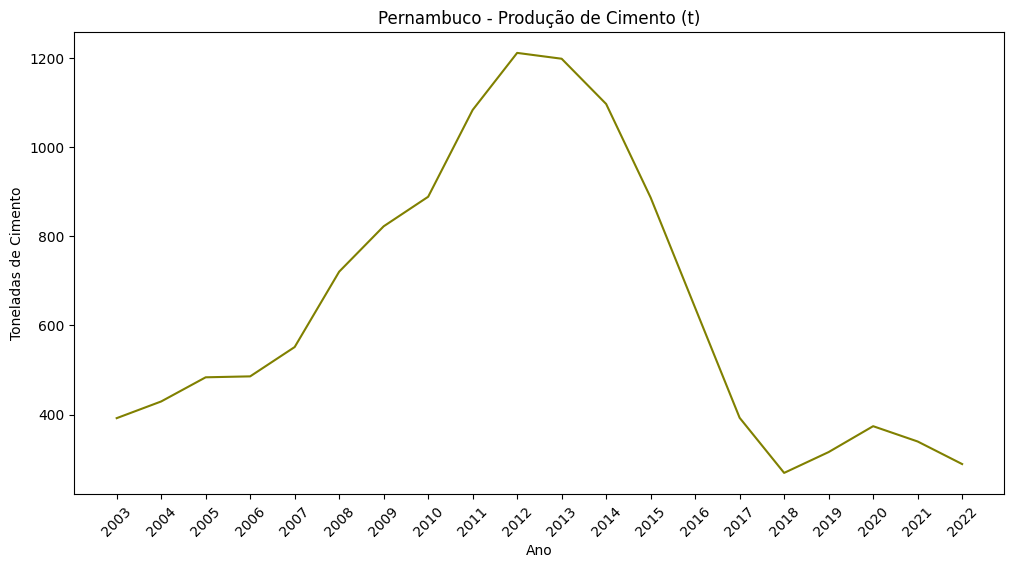

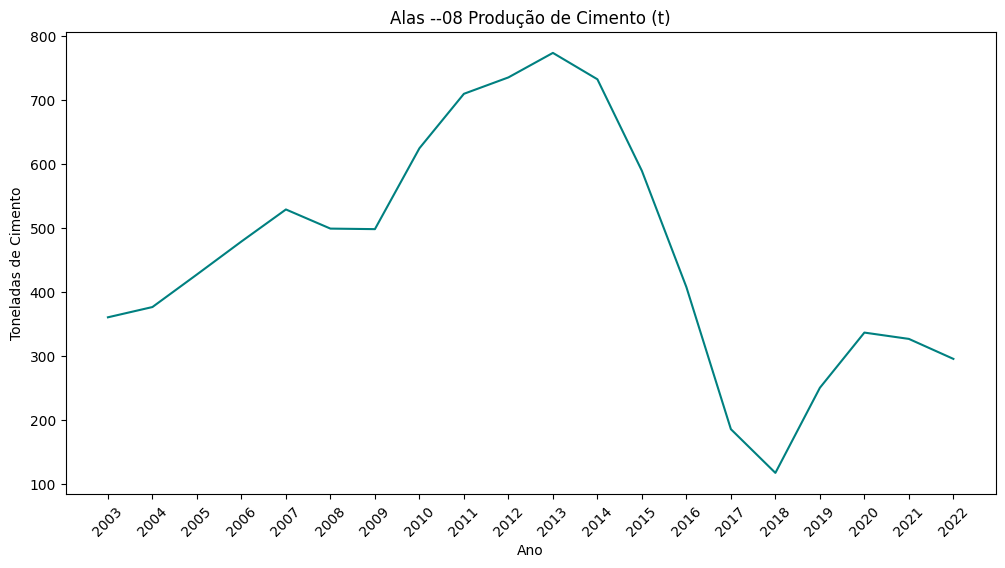

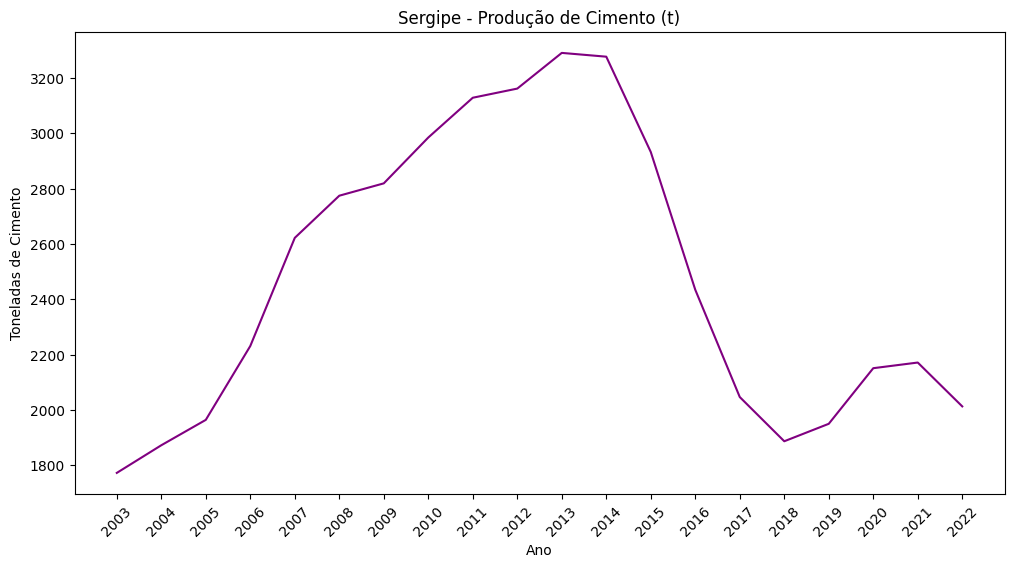

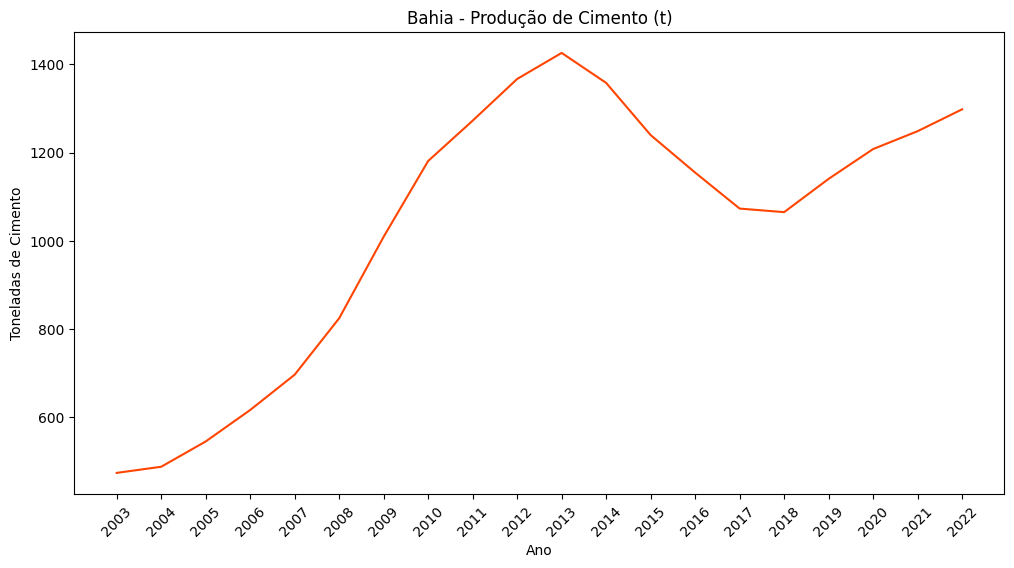

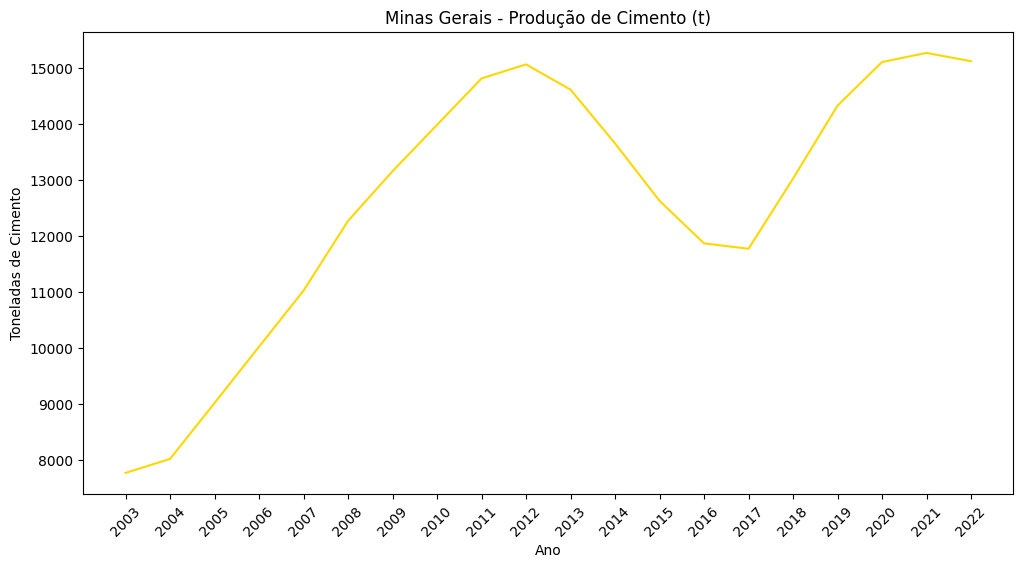

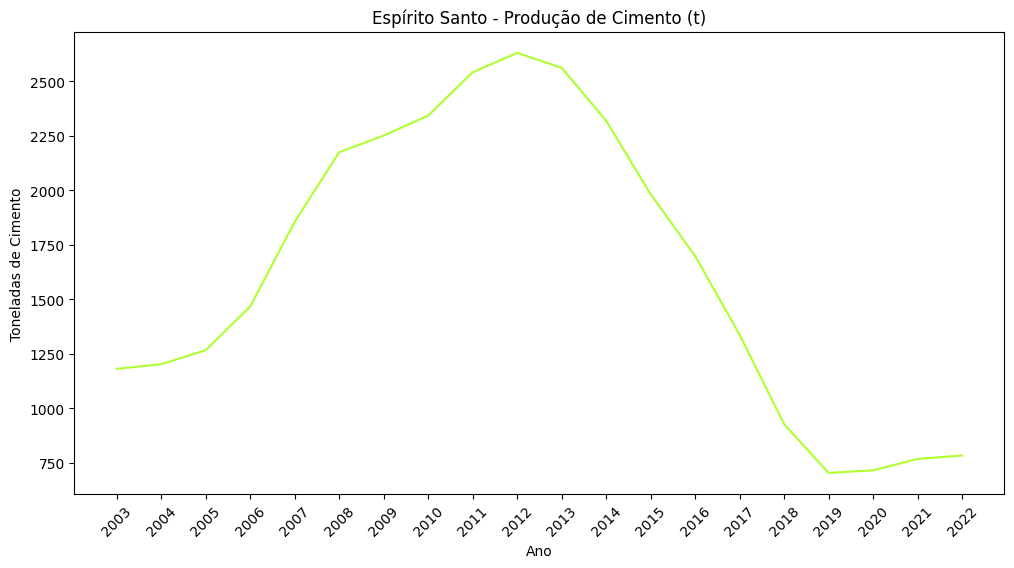

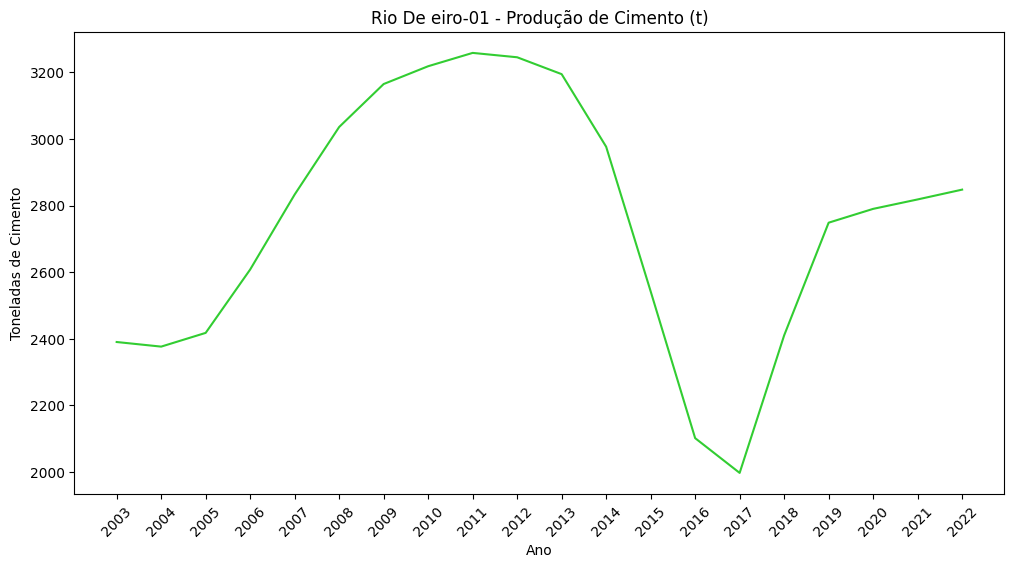

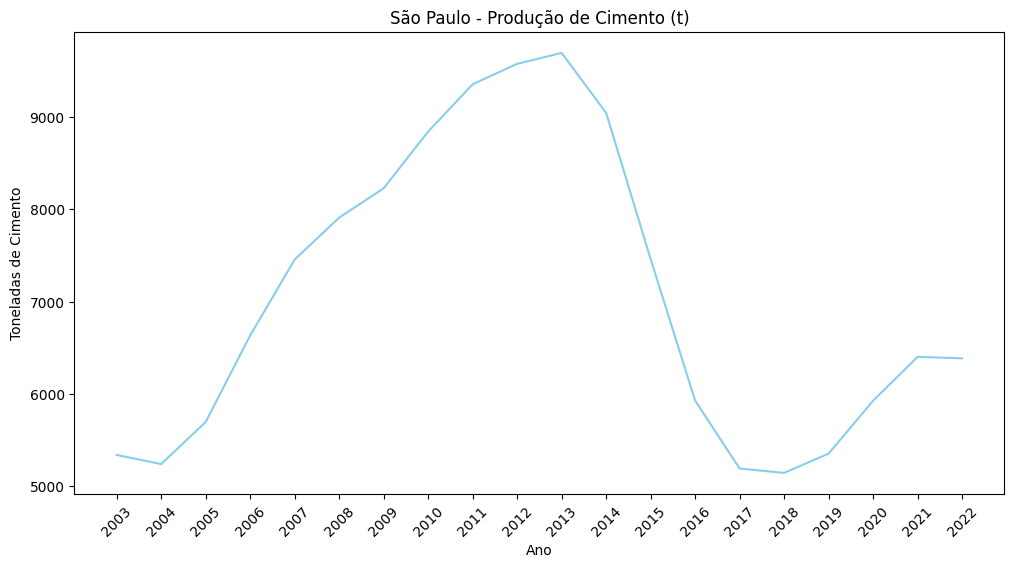

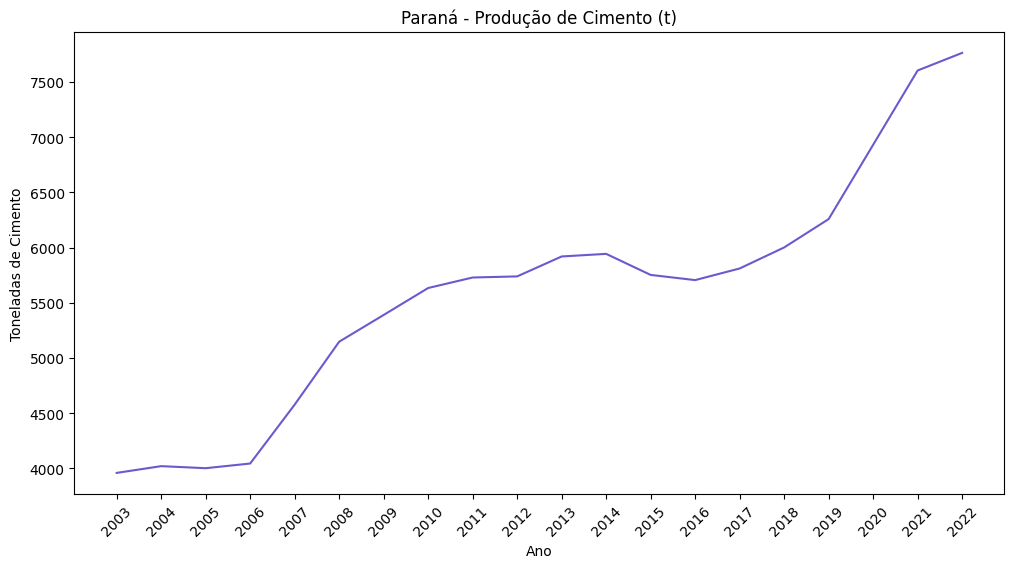

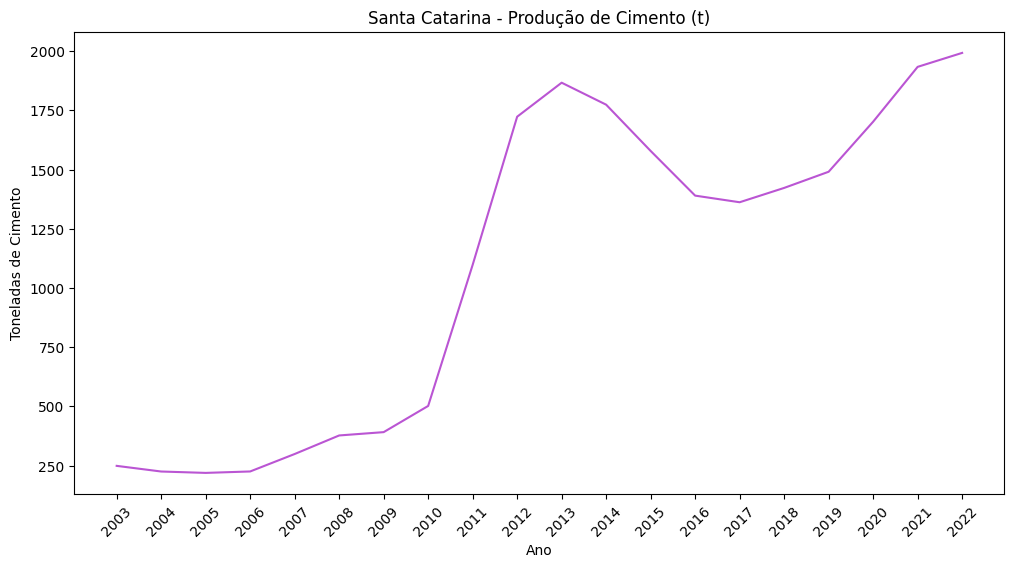

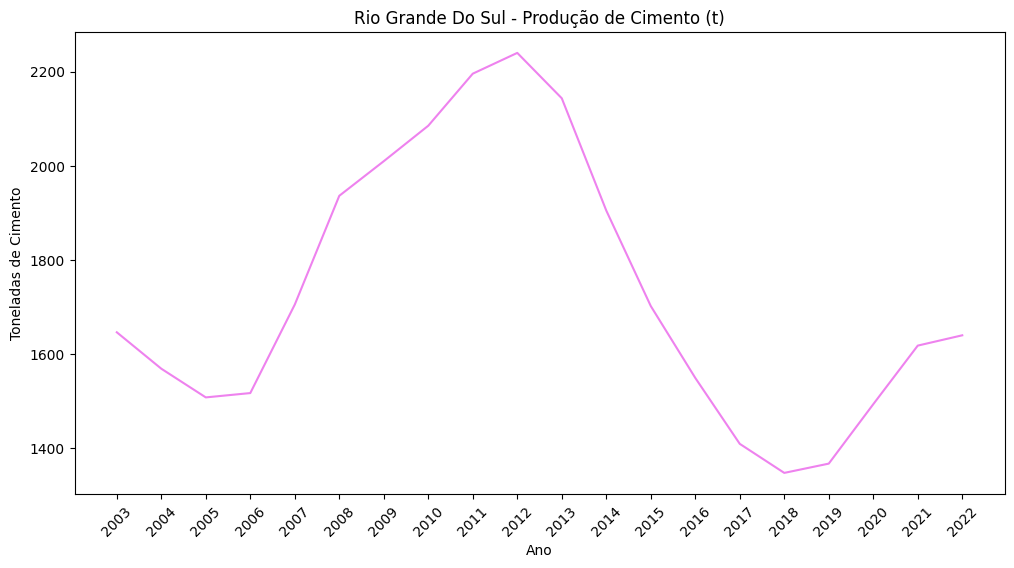

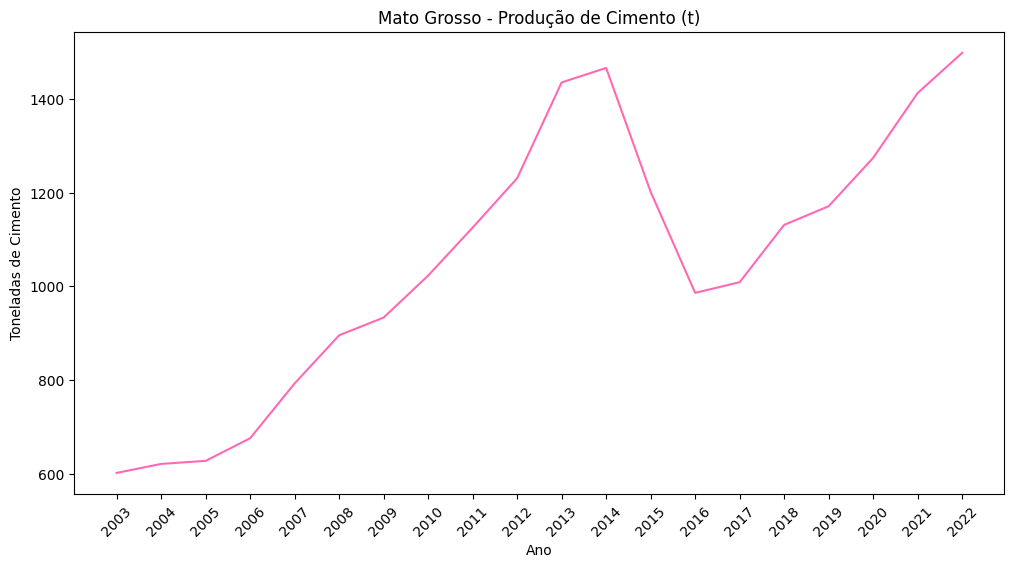

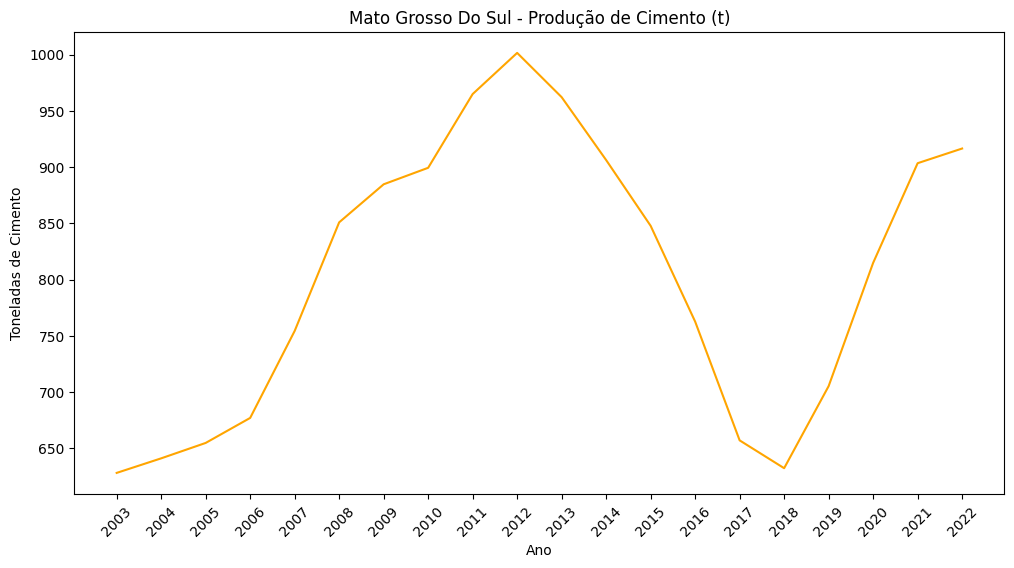

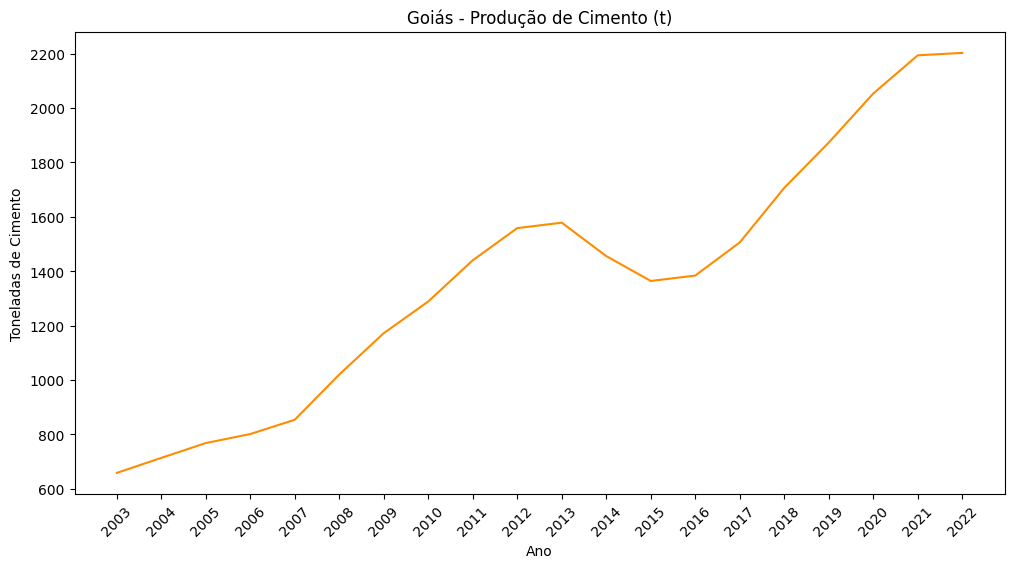

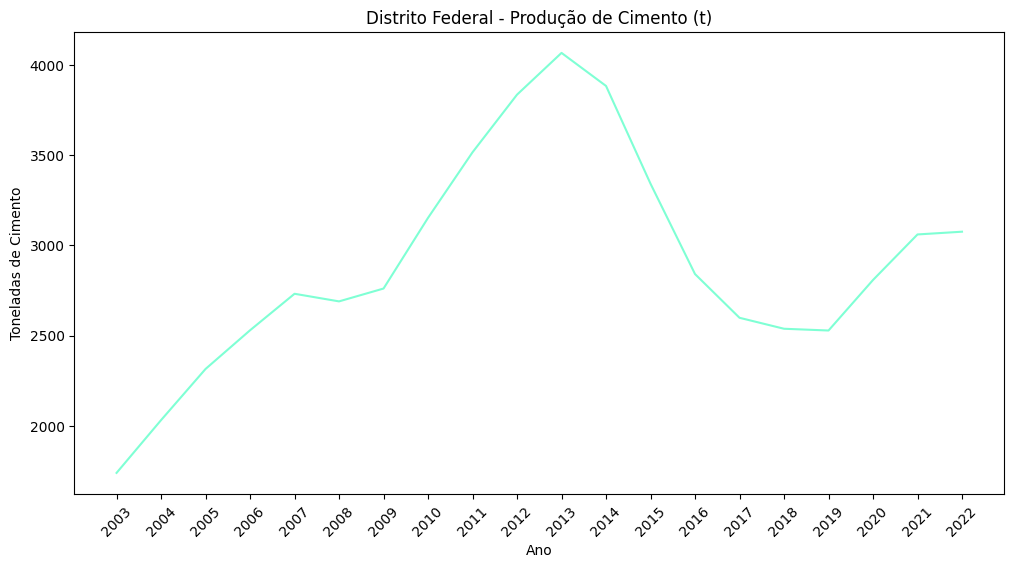

In [14]:
for i, column in enumerate(df_year.columns):
    if i > 1:
        plot_column(df_year[column], color=colors[i])